In [10]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
import requests
from requests_futures.sessions import FuturesSession
from bs4 import BeautifulSoup
import re
import urllib 
import os
import sys
import pandas as pd
import pickle
sys.path.append('/usr/local/lib/python2.7/dist-packages') 
import vincent
import json
vincent.core.initialize_notebook()

In [11]:
industry_codes_2digit=pd.read_table(os.getcwd()+'/refs/NAICS_2digit.txt',index_col=False, sep=';')
industry_codes_2digit['NAICS_2digit']=industry_codes_2digit['NAICS_2digit'].astype(str)
industry_codes_2digit

,NAICS_2digit,Industry_Group
0,11,"Agriculture, Forestry, Fishing and Hunting"
1,21,"Mining, Quarrying, and Oil and Gas Extraction"
2,22,Utilities
3,23,Construction
4,31,Manufacturing
5,32,Manufacturing
6,33,Manufacturing
7,42,Wholesale Trade
8,44,Retail Trade
9,45,Retail Trade


In [12]:
industry_codes=pd.read_excel(os.getcwd()+'/refs/6-digit_2012_Codes.xls',sheetname='2012_6-digit_industries',index_col=False, sep=';')
print industry_codes.shape
industry_codes.columns=['NAICS2012','Industry_Desc']
industry_codes=industry_codes.drop(industry_codes.index[0]) #remove empty row
industry_codes['NAICS2012']=industry_codes['NAICS2012'].astype(int).astype(str)
industry_codes.head()

(1066, 2)


,NAICS2012,Industry_Desc
1,111110,Soybean Farming
2,111120,Oilseed (except Soybean) Farming
3,111130,Dry Pea and Bean Farming
4,111140,Wheat Farming
5,111150,Corn Farming


In [13]:
##Get County FIPS IDs
county_fips_url='http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt'
county_fips=pd.read_table(county_fips_url, sep=',', header=None, names=['state_abbrev','state_fp', 'county_fp', 'countyName', 'fp_class_code'])
county_fips['state_county_code']=county_fips['state_fp']*1000+county_fips['county_fp']
county_fips['st_county_id_str']=county_fips['state_county_code'].map("{:05}".format)
county_fips.head()

,state_abbrev,state_fp,county_fp,countyName,fp_class_code,state_county_code,st_county_id_str
0,AL,1,1,Autauga County,H1,1001,01001
1,AL,1,3,Baldwin County,H1,1003,01003
2,AL,1,5,Barbour County,H1,1005,01005
3,AL,1,7,Bibb County,H1,1007,01007
4,AL,1,9,Blount County,H1,1009,01009


In [14]:
#econ example call: http://api.census.gov/data/2012/ewks?get=ST,COUNTY,EMP,RCPTOT,PAYANN,ESTAB,NAICS2012,OPTAX&for=state:*&NAICS2012=54&key=77912556e5965544a3093efa3cb2305807fbe56c
url='http://api.census.gov/data/2012/ewks?get=ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX&for=place:*&in=state:06&&NAICS2012=31-33&key=77912556e5965544a3093efa3cb2305807fbe56c'
session = FuturesSession(max_workers=15)

# multiple resolutions available:state, county, censusplace, msa, usf, statesenate, statehouse, congdistrict, tribalnation.
# print counties_stringsDF.head(1)
# urls=(base_url+counties_stringsDF+'?format=json').tolist()

#Send multiple requests at once
futures = session.get(url) 
state_response = futures.result()

In [15]:
print state_response.url
print state_response.text[0:500]

http://api.census.gov/data/2012/ewks?get=ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX&for=place:*&in=state:06&&NAICS2012=31-33&key=77912556e5965544a3093efa3cb2305807fbe56c
[["ST","COUNTY","NAICS2012","EMP","RCPTOT","PAYANN","ESTAB","OPTAX","NAICS2012","state","place"],
["06","001","31-33","3006","1130161","273989","50","99","31-33","06","00562"],
["06","001","31-33","39","0","1277","9","99","31-33","06","00674"],
["06","001","31-33","0","1646","0","4","99","31-33","06","02980"],
["06","001","31-33","3744","0","241146","152","99","31-33","06","06000"],
["06","001","31-33","15","1638","575","7","99","31-33","06","11964"],
["06","001","31-33","53","5349","1995","6","


In [16]:
column_names=re.split(',', 'CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX')
base_url='http://api.census.gov/data/2012/ewks?get=CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX&for=county:*&&NAICS2012='
and_key='&key=77912556e5965544a3093efa3cb2305807fbe56c'
session = FuturesSession(max_workers=15)
urls=[]
for industry in industry_codes['NAICS2012']:
    urls.append(base_url+industry.strip()+and_key)
#     print base_url+industry+and_key
    
#Send multiple requests at once
futures = [session.get(url) for url in urls]
industry_responses = [future.result() for future in futures]

In [17]:
import pickle

In [18]:
# output = open('industry_responses.pkl', 'wb')
# pickle.dump(industry_responses, output)
# output.close()

In [19]:
from StringIO import StringIO as strIO 

In [20]:
industryDFs=[]
for industry_response in industry_responses:
    try:
        braces_removed=re.sub('\[|]','',industry_response.text)
        industryDFs.append(pd.read_csv(strIO(braces_removed), sep=","))
    except:
        1 #print 'no data for an industry'

industryDF=pd.concat(industryDFs)

In [21]:
industryDF.shape

(444402, 13)

In [22]:
industryDF['NAICS2012']=industryDF['NAICS2012'].astype(str)

In [23]:
industryDF['NAICS_2digit']=industryDF['NAICS2012'].apply(lambda x: x[0:2])
industryDF['NAICS_2digit'].head()

0    22
1    22
2    22
3    22
4    22
Name: NAICS_2digit, dtype: object

In [24]:
industryDF=pd.merge(industryDF, industry_codes, on='NAICS2012' )
industryDF.shape

(444402, 15)

In [25]:
industryDF=pd.merge(industryDF,industry_codes_2digit, on='NAICS_2digit')
industryDF.tail()

,CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX,NAICS2012.1,state,county,Unnamed: 12,NAICS_2digit,Industry_Desc,Industry_Group
444397,999,56,37,812990,0,0,0,1,T,812990,56,37,NaN,81,All Other Personal Services,Other Services (except Public Administration)
444398,999,56,39,812990,0,0,0,4,A,812990,56,39,NaN,81,All Other Personal Services,Other Services (except Public Administration)
444399,999,56,39,812990,0,0,0,4,T,812990,56,39,NaN,81,All Other Personal Services,Other Services (except Public Administration)
444400,999,56,41,812990,0,0,0,1,A,812990,56,41,NaN,81,All Other Personal Services,Other Services (except Public Administration)
444401,999,56,41,812990,0,0,0,1,T,812990,56,41,NaN,81,All Other Personal Services,Other Services (except Public Administration)


In [26]:
industryDF.NAICS_2digit.value_counts()

42    61339
44    54774
62    53736
54    46515
81    34218
45    23952
72    23623
71    20403
52    19028
48    18133
53    18111
56    17649
33    13113
61    11437
51     9300
32     7110
22     5407
31     3364
49     3190
dtype: int64

In [27]:
industryDF.shape

(444402, 16)

In [28]:
industryDF.head()

,CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX,NAICS2012.1,state,county,Unnamed: 12,NAICS_2digit,Industry_Desc,Industry_Group
0,999,1,15,221111,0,0,0,1,99,221111,1,15,NaN,22,Hydroelectric Power Generation,Utilities
1,142,1,21,221111,0,0,0,2,99,221111,1,21,NaN,22,Hydroelectric Power Generation,Utilities
2,999,1,27,221111,0,0,0,1,99,221111,1,27,NaN,22,Hydroelectric Power Generation,Utilities
3,999,1,51,221111,0,0,0,3,99,221111,1,51,NaN,22,Hydroelectric Power Generation,Utilities
4,999,1,75,221111,0,0,0,1,99,221111,1,75,NaN,22,Hydroelectric Power Generation,Utilities


In [29]:
# industryDF.to_csv('CA_industryDF.csv', sep=',',index=False, encoding='utf-8' )

In [30]:
industryDF['state_county_code']= industryDF['ST']*1000+industryDF['COUNTY']
industryDF=pd.merge(industryDF, county_fips, on='state_county_code' )
industryDF['Industry_Group']=industryDF['Industry_Group'].apply(lambda x: x.strip())
by_county=industryDF[['state_county_code','Industry_Group', 'EMP','RCPTOT','PAYANN']].groupby(['state_county_code','Industry_Group']).sum()

In [31]:
industryDF.head()

,CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX,NAICS2012.1,...,NAICS_2digit,Industry_Desc,Industry_Group,state_county_code,state_abbrev,state_fp,county_fp,countyName,fp_class_code,st_county_id_str
0,999,1,15,221111,0,0,0,1,99,221111,...,22,Hydroelectric Power Generation,Utilities,1015,AL,1,15,Calhoun County,H1,01015
1,999,1,15,221115,0,0,0,1,99,221115,...,22,Wind Electric Power Generation,Utilities,1015,AL,1,15,Calhoun County,H1,01015
2,999,1,15,221122,0,0,0,9,99,221122,...,22,Electric Power Distribution,Utilities,1015,AL,1,15,Calhoun County,H1,01015
3,999,1,15,221210,0,0,0,1,99,221210,...,22,Natural Gas Distribution,Utilities,1015,AL,1,15,Calhoun County,H1,01015
4,999,1,15,221310,0,0,0,1,99,221310,...,22,Water Supply and Irrigation Systems,Utilities,1015,AL,1,15,Calhoun County,H1,01015


In [32]:
by_county.head(10)

EMP  RCPTOT  PAYANN
state_county_code Industry_Group                                          
1001              Accommodation and Food Services      888   32462   11184
                  Finance and Insurance                242       0    8877
                  Manufacturing                          0       0       0
                  Real Estate and Rental and Leasing    36    5139     906
                  Retail Trade                         305  127404    5802
                  Transportation and Warehousing        12    1292     245
                  Utilities                              0       0       0
                  Wholesale Trade                        0       0       0
1003              Accommodation and Food Services     8780  413442  123838
                  Finance and Insurance               1207   69105   59446

In [33]:
by_county_sum=by_county.reset_index().groupby('state_county_code').sum()

In [34]:
by_county_sum.columns=['tot_county_emp', 'tot_county_rcp', 'tot_county_ann_pay']
by_county_sum.head()

,tot_county_emp,tot_county_rcp,tot_county_ann_pay
state_county_code,,,
1001,1483,166297,27014
1003,20375,3223110,447324
1005,1238,180526,28864
1007,191,30030,3062
1009,755,76132,14648


In [35]:
county_propDF=pd.merge(by_county.reset_index(), by_county_sum.reset_index(), on='state_county_code' )

In [36]:
county_propDF['ind_prop_county_emp']=county_propDF.EMP*1.0/county_propDF.tot_county_emp
county_propDF['ind_prop_county_rcp']=county_propDF.RCPTOT*1.0/county_propDF.tot_county_rcp
county_propDF['ind_prop_county_pay']=county_propDF.PAYANN*1.0/county_propDF.tot_county_ann_pay

county_propDF.head()

,state_county_code,Industry_Group,EMP,RCPTOT,PAYANN,tot_county_emp,tot_county_rcp,tot_county_ann_pay,ind_prop_county_emp,ind_prop_county_rcp,ind_prop_county_pay
0,1001,Accommodation and Food Services,888,32462,11184,1483,166297,27014,0.598786,0.195205,0.414008
1,1001,Finance and Insurance,242,0,8877,1483,166297,27014,0.163183,0.000000,0.328607
2,1001,Manufacturing,0,0,0,1483,166297,27014,0.000000,0.000000,0.000000
3,1001,Real Estate and Rental and Leasing,36,5139,906,1483,166297,27014,0.024275,0.030903,0.033538
4,1001,Retail Trade,305,127404,5802,1483,166297,27014,0.205664,0.766123,0.214778


In [37]:
county_ind_prop_pivot=county_propDF[[ \
                                     'state_county_code',
                                     'Industry_Group',
                                     'ind_prop_county_emp',
                                     'ind_prop_county_rcp',
                                     'ind_prop_county_pay']]\
                                    .pivot(index='state_county_code', columns='Industry_Group')

In [38]:
county_ind_prop_pivot.head()

ind_prop_county_emp  \
Industry_Group    Accommodation and Food Services   
state_county_code                                   
1001                                     0.598786   
1003                                     0.430920   
1005                                     0.373183   
1007                                     0.481675   
1009                                     0.558940   

                                                                                            \
Industry_Group    Administrative and Support and Waste Management and Remediation Services   
state_county_code                                                                            
1001                                                             NaN                         
1003                                                             NaN                         
1005                                                             NaN                         
1007                                                             NaN                         
1009                                                             NaN                         

                                                                            \
Industry_Group    Arts, Entertainment, and Recreation Educational Services   
state_county_code                                                            
1001                                              NaN                  NaN   
1003                                              NaN                  NaN   
1005                                              NaN                  NaN   
1007                                              NaN                  NaN   
1009                                              NaN                  NaN   

                                                                           \
Industry_Group    Finance and Insurance Health Care and Social Assistance   
state_county_code                                                           
1001                           0.163183                               NaN   
1003                           0.059239                               NaN   
1005                           0.121971                               NaN   
1007                           0.000000                               NaN   
1009                           0.188079                               NaN   

                                             \
Industry_Group    Information Manufacturing   
state_county_code                             
1001                      NaN      0.000000   
1003                      NaN      0.006086   
1005                      NaN      0.000000   
1007                      NaN           NaN   
1009                      NaN      0.011921   

                                                                 \
Industry_Group    Other Services (except Public Administration)   
state_county_code                                                 
1001                                                        NaN   
1003                                                        NaN   
1005                                                        NaN   
1007                                                        NaN   
1009                                                        NaN   

                                                                    \
Industry_Group    Professional, Scientific, and Technical Services   
state_county_code                                                    
1001                                                           NaN   
1003                                                           NaN   
1005                                                           NaN   
1007                                                           NaN   
1009                                                           NaN   

                        ...                     ind_prop_county_pay  \
Industry_Group          ...       Health Care and Social Assista

In [39]:
county_ind_prop_pivot=county_ind_prop_pivot.fillna(0)
county_ind_prop_pivot.head()

ind_prop_county_emp  \
Industry_Group    Accommodation and Food Services   
state_county_code                                   
1001                                     0.598786   
1003                                     0.430920   
1005                                     0.373183   
1007                                     0.481675   
1009                                     0.558940   

                                                                                            \
Industry_Group    Administrative and Support and Waste Management and Remediation Services   
state_county_code                                                                            
1001                                                               0                         
1003                                                               0                         
1005                                                               0                         
1007                                                               0                         
1009                                                               0                         

                                                                            \
Industry_Group    Arts, Entertainment, and Recreation Educational Services   
state_county_code                                                            
1001                                                0                    0   
1003                                                0                    0   
1005                                                0                    0   
1007                                                0                    0   
1009                                                0                    0   

                                                                           \
Industry_Group    Finance and Insurance Health Care and Social Assistance   
state_county_code                                                           
1001                           0.163183                                 0   
1003                           0.059239                                 0   
1005                           0.121971                                 0   
1007                           0.000000                                 0   
1009                           0.188079                                 0   

                                             \
Industry_Group    Information Manufacturing   
state_county_code                             
1001                        0      0.000000   
1003                        0      0.006086   
1005                        0      0.000000   
1007                        0      0.000000   
1009                        0      0.011921   

                                                                 \
Industry_Group    Other Services (except Public Administration)   
state_county_code                                                 
1001                                                          0   
1003                                                          0   
1005                                                          0   
1007                                                          0   
1009                                                          0   

                                                                    \
Industry_Group    Professional, Scientific, and Technical Services   
state_county_code                                                    
1001                                                             0   
1003                                                             0   
1005                                                             0   
1007                                                             0   
1009                                                             0   

                        ...                     ind_prop_county_pay  \
Industry_Group          ...       Health Care and Social Assista

In [40]:
county_ind_prop_pivot.shape

(3140, 45)

In [41]:
output = open('county_ind_prop_pivot.pkl', 'wb')
pickle.dump(county_ind_prop_pivot, output)
output.close()

In [42]:
from sklearn import cluster, mixture
from sklearn import metrics

In [43]:
km_ind_2=cluster.KMeans(n_clusters=2,n_init=20).fit(county_ind_prop_pivot)
km_ind_3=cluster.KMeans(n_clusters=3,n_init=20).fit(county_ind_prop_pivot)
km_ind_4=cluster.KMeans(n_clusters=4,n_init=20).fit(county_ind_prop_pivot)
km_ind_5=cluster.KMeans(n_clusters=5,n_init=20).fit(county_ind_prop_pivot)
km_ind_6=cluster.KMeans(n_clusters=6,n_init=20).fit(county_ind_prop_pivot)
km_ind_7=cluster.KMeans(n_clusters=7,n_init=20).fit(county_ind_prop_pivot)
km_ind_8=cluster.KMeans(n_clusters=8,n_init=20).fit(county_ind_prop_pivot)
km_ind_9=cluster.KMeans(n_clusters=9,n_init=20).fit(county_ind_prop_pivot)
km_ind_10=cluster.KMeans(n_clusters=10,n_init=20).fit(county_ind_prop_pivot)
km_ind_15=cluster.KMeans(n_clusters=15,n_init=20).fit(county_ind_prop_pivot)
km_ind_20=cluster.KMeans(n_clusters=20,n_init=20).fit(county_ind_prop_pivot)
km_ind_30=cluster.KMeans(n_clusters=30,n_init=20).fit(county_ind_prop_pivot)
km_ind_100=cluster.KMeans(n_clusters=100,n_init=20).fit(county_ind_prop_pivot)

In [44]:
kmean_test=pd.DataFrame([
        ("KM 2 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_2.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 3 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_3.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 4 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_4.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 5 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_5.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 6 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_6.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 7 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_7.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 8 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_8.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 9 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_9.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 10 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_10.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 15 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_15.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 20 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_20.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 30 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_30.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 40 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_100.predict(county_ind_prop_pivot), metric='euclidean'))

], columns=["Model", "Silhouette"])

/opt/conda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


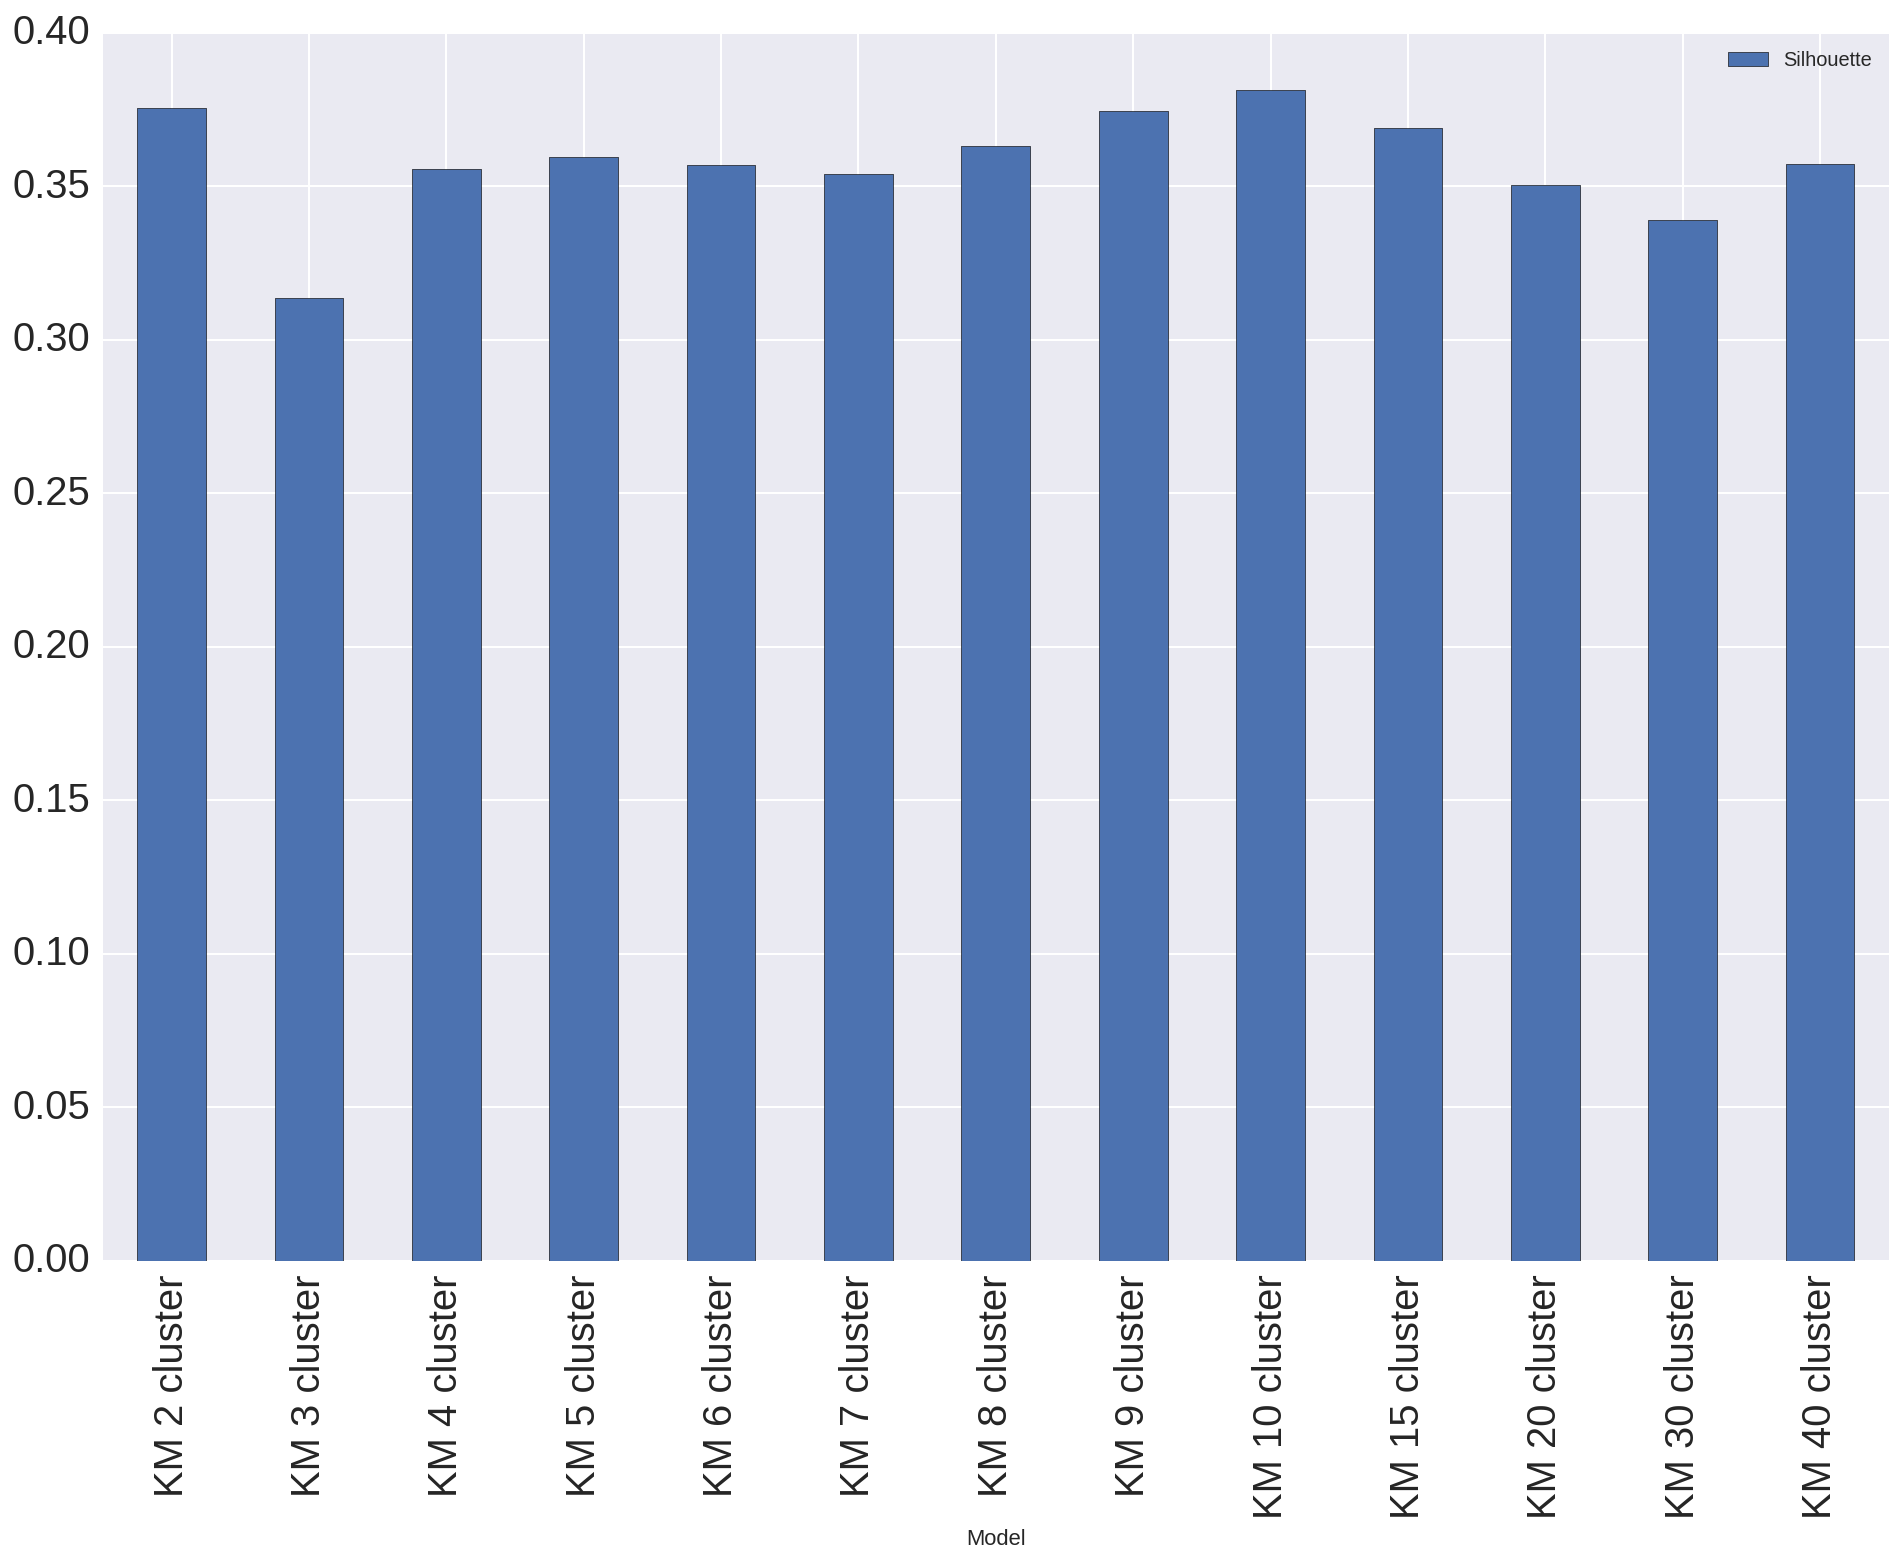

In [45]:
p1=kmean_test.plot(x="Model", y="Silhouette", kind="bar", figsize=(16,11),fontsize=20)
p1

In [46]:
fig = p1.get_figure()
fig.savefig('keans_cluster_compare.pdf', pad_inches='tight')

In [47]:
gmm_ind_2=mixture.GMM(n_components=2,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_3=mixture.GMM(n_components=3,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_4=mixture.GMM(n_components=4,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_5=mixture.GMM(n_components=5,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_6=mixture.GMM(n_components=6,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_7=mixture.GMM(n_components=7,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_8=mixture.GMM(n_components=8,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_9=mixture.GMM(n_components=9,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_10=mixture.GMM(n_components=10,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_15=mixture.GMM(n_components=15,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_20=mixture.GMM(n_components=20,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_30=mixture.GMM(n_components=30,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_40=mixture.GMM(n_components=40,n_init=20).fit(county_ind_prop_pivot)

In [48]:
# metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_2.predict(county_ind_prop_pivot), metric='euclidean')

In [49]:
gmm_test=pd.DataFrame([
        ("GMM 2 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_2.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 3 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_3.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 4 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_4.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 5 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_5.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 6 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_6.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 7 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_7.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 8 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_8.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 9 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_9.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 10 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_10.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 15 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_15.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 20 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_20.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 30 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_30.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 40 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_40.predict(county_ind_prop_pivot), metric='euclidean'))

        
    ], columns=["Model", "Silhouette"])

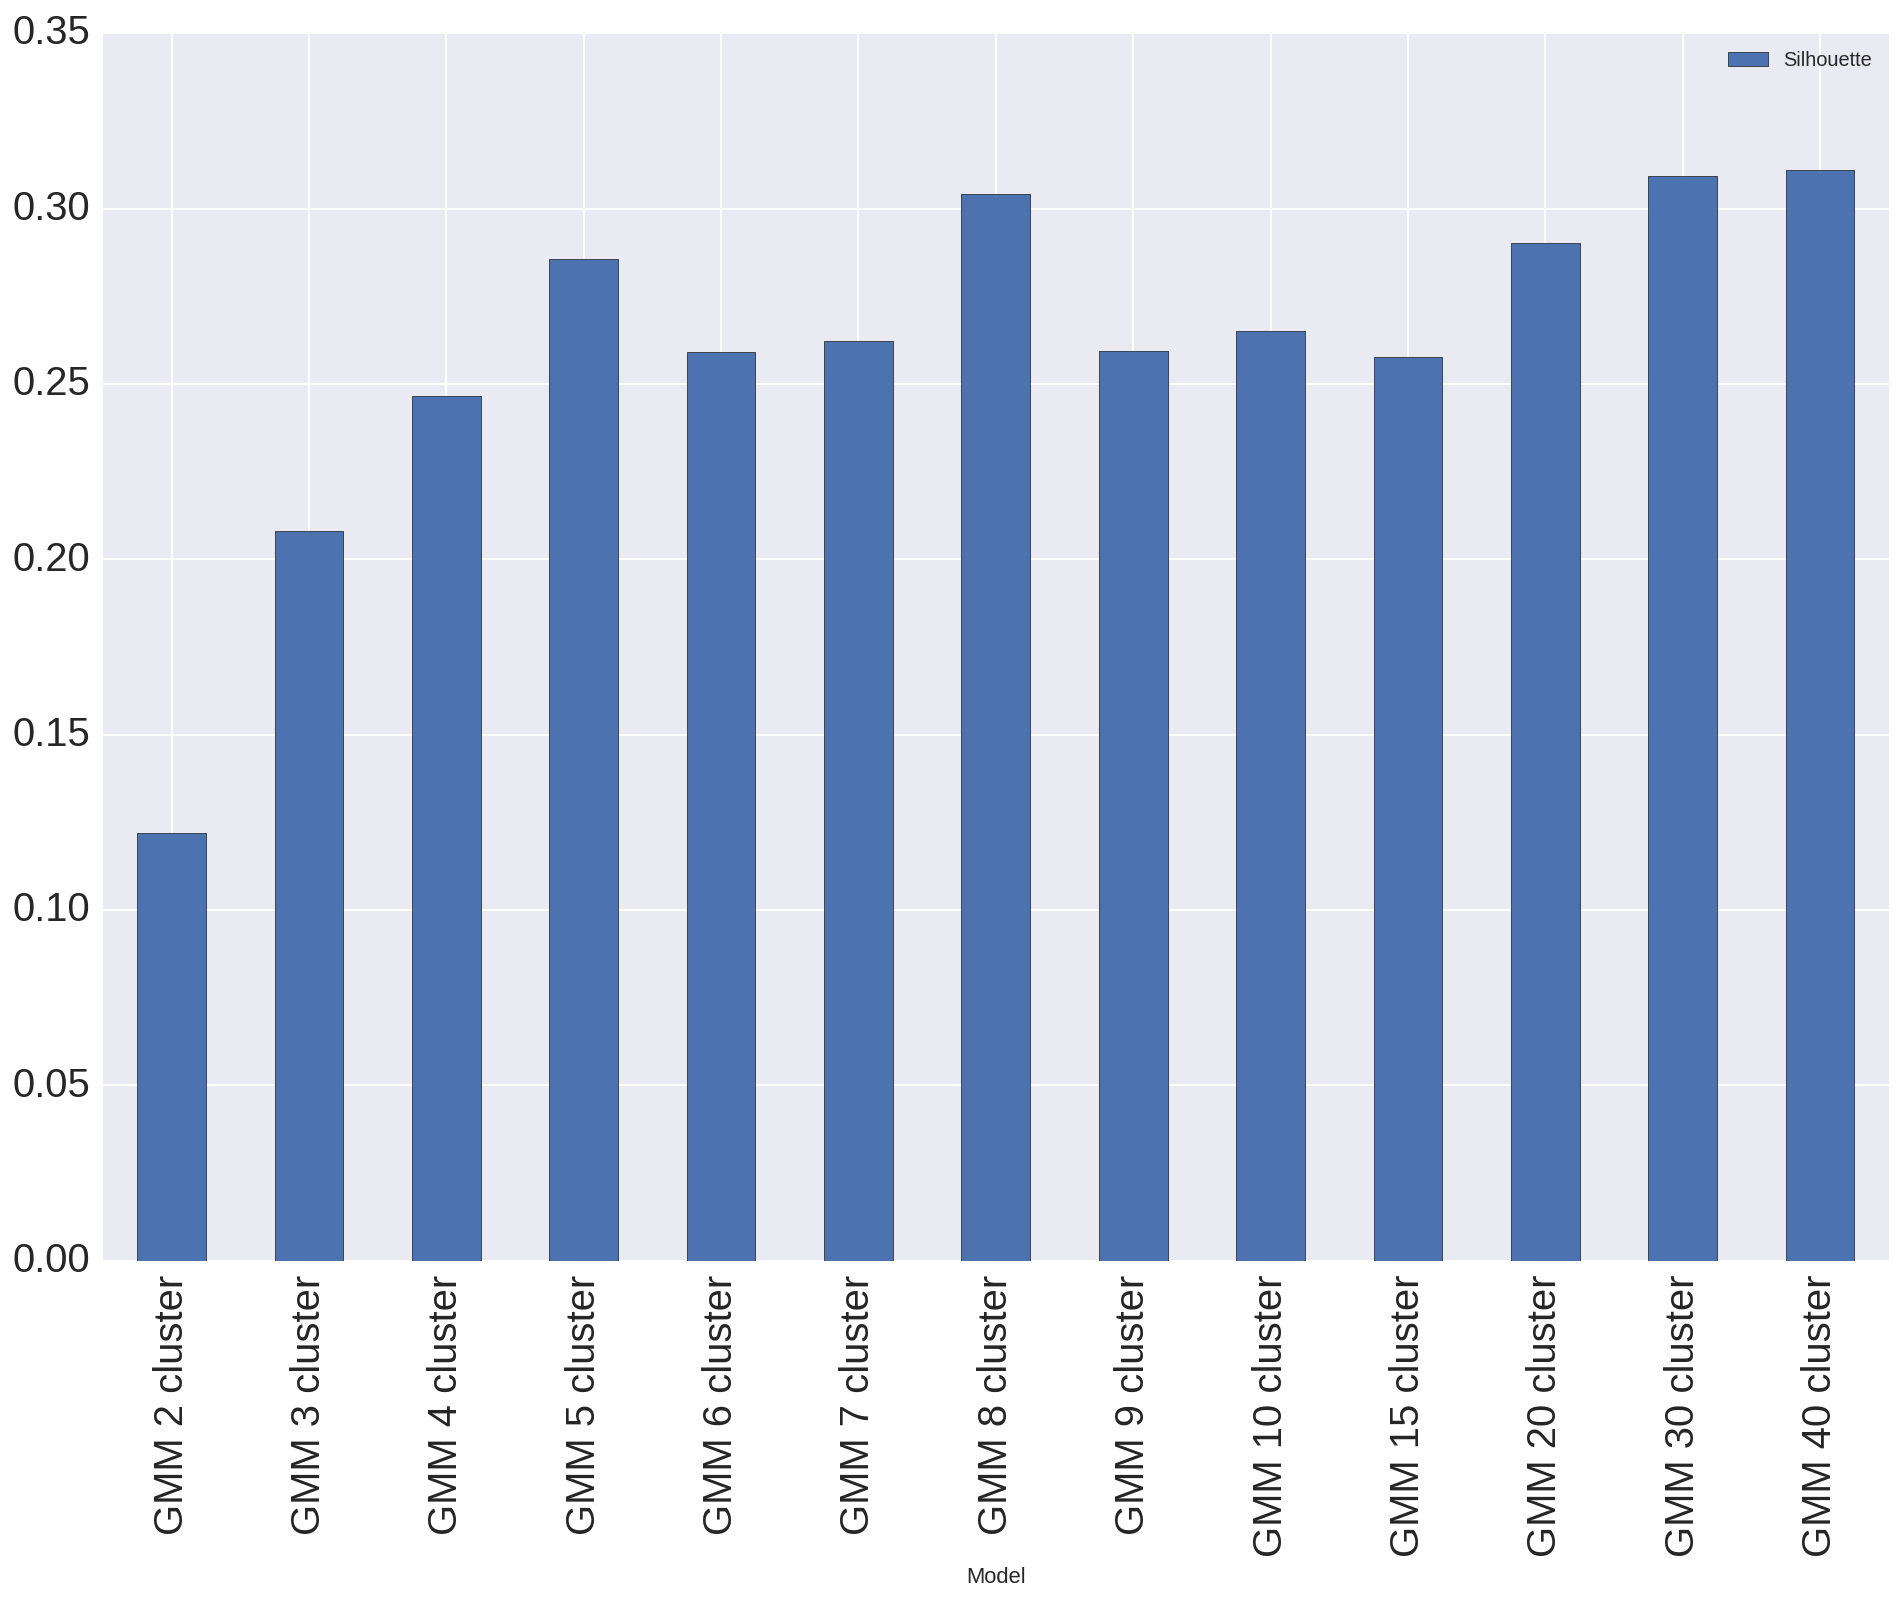

In [50]:
p2=gmm_test.plot(x="Model", y="Silhouette", kind="bar", figsize=(16,11),fontsize=20)

In [51]:
fig = p2.get_figure()
fig.savefig('gmm_components.pdf', pad_inches='tight')

(array([ 2356.,   784.]), array([0, 1, 2]), <a list of 2 Patch objects>)

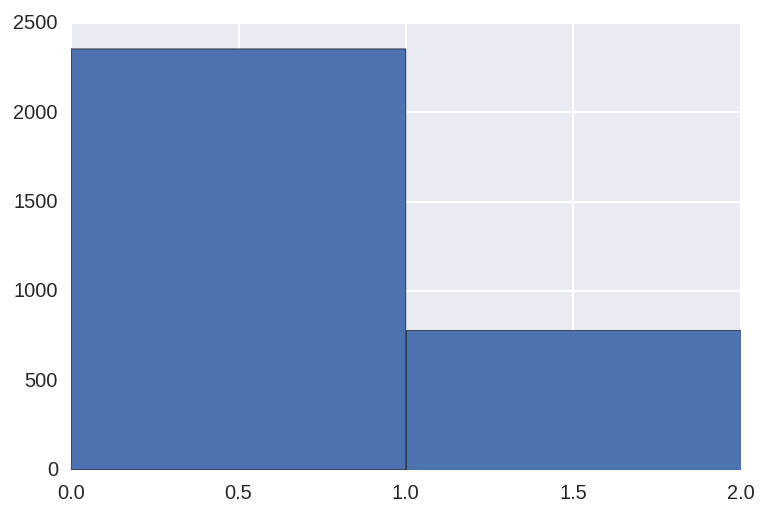

In [52]:
import numpy as np
pl.hist(km_ind_2.predict(county_ind_prop_pivot), bins=[0,1,2])

(array([  950.,   687.,   371.,  1132.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

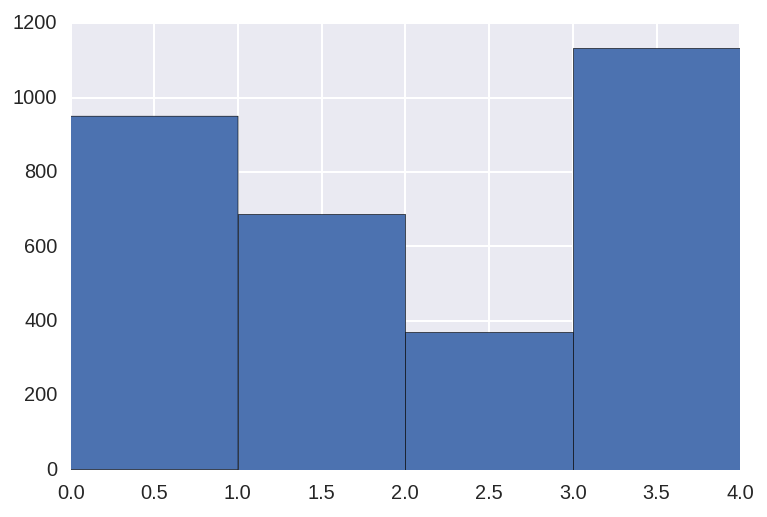

In [53]:
import numpy as np
pl.hist(km_ind_4.predict(county_ind_prop_pivot), bins=[0,1,2,3,4])

In [54]:
kmeans_2_clusters=km_ind_2.predict(county_ind_prop_pivot)
kmeans_4_clusters=km_ind_4.predict(county_ind_prop_pivot)

In [55]:
county_ind_prop_pivot['kmeans_2_cluster']=kmeans_2_clusters
county_ind_prop_pivot['kmeans_4_cluster']=kmeans_4_clusters

In [56]:
county_ind_prop_pivot.head()

ind_prop_county_emp  \
Industry_Group    Accommodation and Food Services   
state_county_code                                   
1001                                     0.598786   
1003                                     0.430920   
1005                                     0.373183   
1007                                     0.481675   
1009                                     0.558940   

                                                                                            \
Industry_Group    Administrative and Support and Waste Management and Remediation Services   
state_county_code                                                                            
1001                                                               0                         
1003                                                               0                         
1005                                                               0                         
1007                                                               0                         
1009                                                               0                         

                                                                            \
Industry_Group    Arts, Entertainment, and Recreation Educational Services   
state_county_code                                                            
1001                                                0                    0   
1003                                                0                    0   
1005                                                0                    0   
1007                                                0                    0   
1009                                                0                    0   

                                                                           \
Industry_Group    Finance and Insurance Health Care and Social Assistance   
state_county_code                                                           
1001                           0.163183                                 0   
1003                           0.059239                                 0   
1005                           0.121971                                 0   
1007                           0.000000                                 0   
1009                           0.188079                                 0   

                                             \
Industry_Group    Information Manufacturing   
state_county_code                             
1001                        0      0.000000   
1003                        0      0.006086   
1005                        0      0.000000   
1007                        0      0.000000   
1009                        0      0.011921   

                                                                 \
Industry_Group    Other Services (except Public Administration)   
state_county_code                                                 
1001                                                          0   
1003                                                          0   
1005                                                          0   
1007                                                          0   
1009                                                          0   

                                                                    \
Industry_Group    Professional, Scientific, and Technical Services   
state_county_code                                                    
1001                                                             0   
1003                                                             0   
1005                                                             0   
1007                                                             0   
1009                                                             0   

                        ...        ind_prop_county_pay  \
Industry_Group          ...              Manufacturing   
state_county_code  

In [57]:
county_ind_prop_pivot['st_county_id_str']=county_ind_prop_pivot.index.map("{:05}".format)

In [58]:
county_ind_prop_pivot.head()

ind_prop_county_emp  \
Industry_Group    Accommodation and Food Services   
state_county_code                                   
1001                                     0.598786   
1003                                     0.430920   
1005                                     0.373183   
1007                                     0.481675   
1009                                     0.558940   

                                                                                            \
Industry_Group    Administrative and Support and Waste Management and Remediation Services   
state_county_code                                                                            
1001                                                               0                         
1003                                                               0                         
1005                                                               0                         
1007                                                               0                         
1009                                                               0                         

                                                                            \
Industry_Group    Arts, Entertainment, and Recreation Educational Services   
state_county_code                                                            
1001                                                0                    0   
1003                                                0                    0   
1005                                                0                    0   
1007                                                0                    0   
1009                                                0                    0   

                                                                           \
Industry_Group    Finance and Insurance Health Care and Social Assistance   
state_county_code                                                           
1001                           0.163183                                 0   
1003                           0.059239                                 0   
1005                           0.121971                                 0   
1007                           0.000000                                 0   
1009                           0.188079                                 0   

                                             \
Industry_Group    Information Manufacturing   
state_county_code                             
1001                        0      0.000000   
1003                        0      0.006086   
1005                        0      0.000000   
1007                        0      0.000000   
1009                        0      0.011921   

                                                                 \
Industry_Group    Other Services (except Public Administration)   
state_county_code                                                 
1001                                                          0   
1003                                                          0   
1005                                                          0   
1007                                                          0   
1009                                                          0   

                                                                    \
Industry_Group    Professional, Scientific, and Technical Services   
state_county_code                                                    
1001                                                             0   
1003                                                             0   
1005                                                             0   
1007                                                             0   
1009                                                             0   

                        ...         \
Industry_Group          ...          
state_county_code       ...          
1001                 

In [59]:
county_topo='https://raw.githubusercontent.com/wrobstory/vincent_map_data/master/us_counties.topo.json'
geo_data = [{'name': 'counties',
             'url': county_topo,
             'feature': 'us_counties.geo'}]

vis = vincent.Map(data=county_ind_prop_pivot.reset_index(), geo_data=geo_data, scale=1100, projection='albersUsa',
          data_bind='kmeans_4_cluster', data_key='st_county_id_str',
          map_key={'counties': 'properties.FIPS'})
vis.marks[0].properties.enter.stroke_opacity = vincent.ValueRef(value=0.5)
vis.colors(brew='Dark2')
vis.to_json('vega_kmeans_4.json',html_out=True,html_path='vega_kmeans_4_choropleth.html')
vis.display()

In [60]:
county_ind_prop_pivot['kmeans_4_cluster'].value_counts()

3    1132
0     950
1     687
2     371
dtype: int64

In [61]:
county_ind_prop_pivot.head()

ind_prop_county_emp  \
Industry_Group    Accommodation and Food Services   
state_county_code                                   
1001                                     0.598786   
1003                                     0.430920   
1005                                     0.373183   
1007                                     0.481675   
1009                                     0.558940   

                                                                                            \
Industry_Group    Administrative and Support and Waste Management and Remediation Services   
state_county_code                                                                            
1001                                                               0                         
1003                                                               0                         
1005                                                               0                         
1007                                                               0                         
1009                                                               0                         

                                                                            \
Industry_Group    Arts, Entertainment, and Recreation Educational Services   
state_county_code                                                            
1001                                                0                    0   
1003                                                0                    0   
1005                                                0                    0   
1007                                                0                    0   
1009                                                0                    0   

                                                                           \
Industry_Group    Finance and Insurance Health Care and Social Assistance   
state_county_code                                                           
1001                           0.163183                                 0   
1003                           0.059239                                 0   
1005                           0.121971                                 0   
1007                           0.000000                                 0   
1009                           0.188079                                 0   

                                             \
Industry_Group    Information Manufacturing   
state_county_code                             
1001                        0      0.000000   
1003                        0      0.006086   
1005                        0      0.000000   
1007                        0      0.000000   
1009                        0      0.011921   

                                                                 \
Industry_Group    Other Services (except Public Administration)   
state_county_code                                                 
1001                                                          0   
1003                                                          0   
1005                                                          0   
1007                                                          0   
1009                                                          0   

                                                                    \
Industry_Group    Professional, Scientific, and Technical Services   
state_county_code                                                    
1001                                                             0   
1003                                                             0   
1005                                                             0   
1007                                                             0   
1009                                                             0   

                        ...         \
Industry_Group          ...          
state_county_code       ...          
1001                 

In [62]:
county_ind_prop_emp=county_ind_prop_pivot['ind_prop_county_emp'].copy()
county_ind_prop_emp.head()

Industry_Group,Accommodation and Food Services,Administrative and Support and Waste Management and Remediation Services,"Arts, Entertainment, and Recreation",Educational Services,Finance and Insurance,Health Care and Social Assistance,Information,Manufacturing,Other Services (except Public Administration),"Professional, Scientific, and Technical Services",Real Estate and Rental and Leasing,Retail Trade,Transportation and Warehousing,Utilities,Wholesale Trade
state_county_code,,,,,,,,,,,,,,,
1001,0.598786,0,0,0,0.163183,0,0,0.000000,0,0,0.024275,0.205664,0.008092,0.000000,0.000000
1003,0.430920,0,0,0,0.059239,0,0,0.006086,0,0,0.078429,0.386356,0.015264,0.001031,0.022675
1005,0.373183,0,0,0,0.121971,0,0,0.000000,0,0,0.004039,0.320679,0.180129,0.000000,0.000000
1007,0.481675,0,0,0,0.000000,0,0,0.000000,0,0,0.000000,0.518325,0.000000,0.000000,0.000000
1009,0.558940,0,0,0,0.188079,0,0,0.011921,0,0,0.002649,0.180132,0.000000,0.000000,0.058278


In [63]:
county_ind_prop_emp['kmeans_2_cluster']=county_ind_prop_pivot['kmeans_2_cluster']
county_ind_prop_emp['kmeans_4_cluster']=county_ind_prop_pivot['kmeans_4_cluster']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8250098690>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f8243090a90>]], dtype=object)

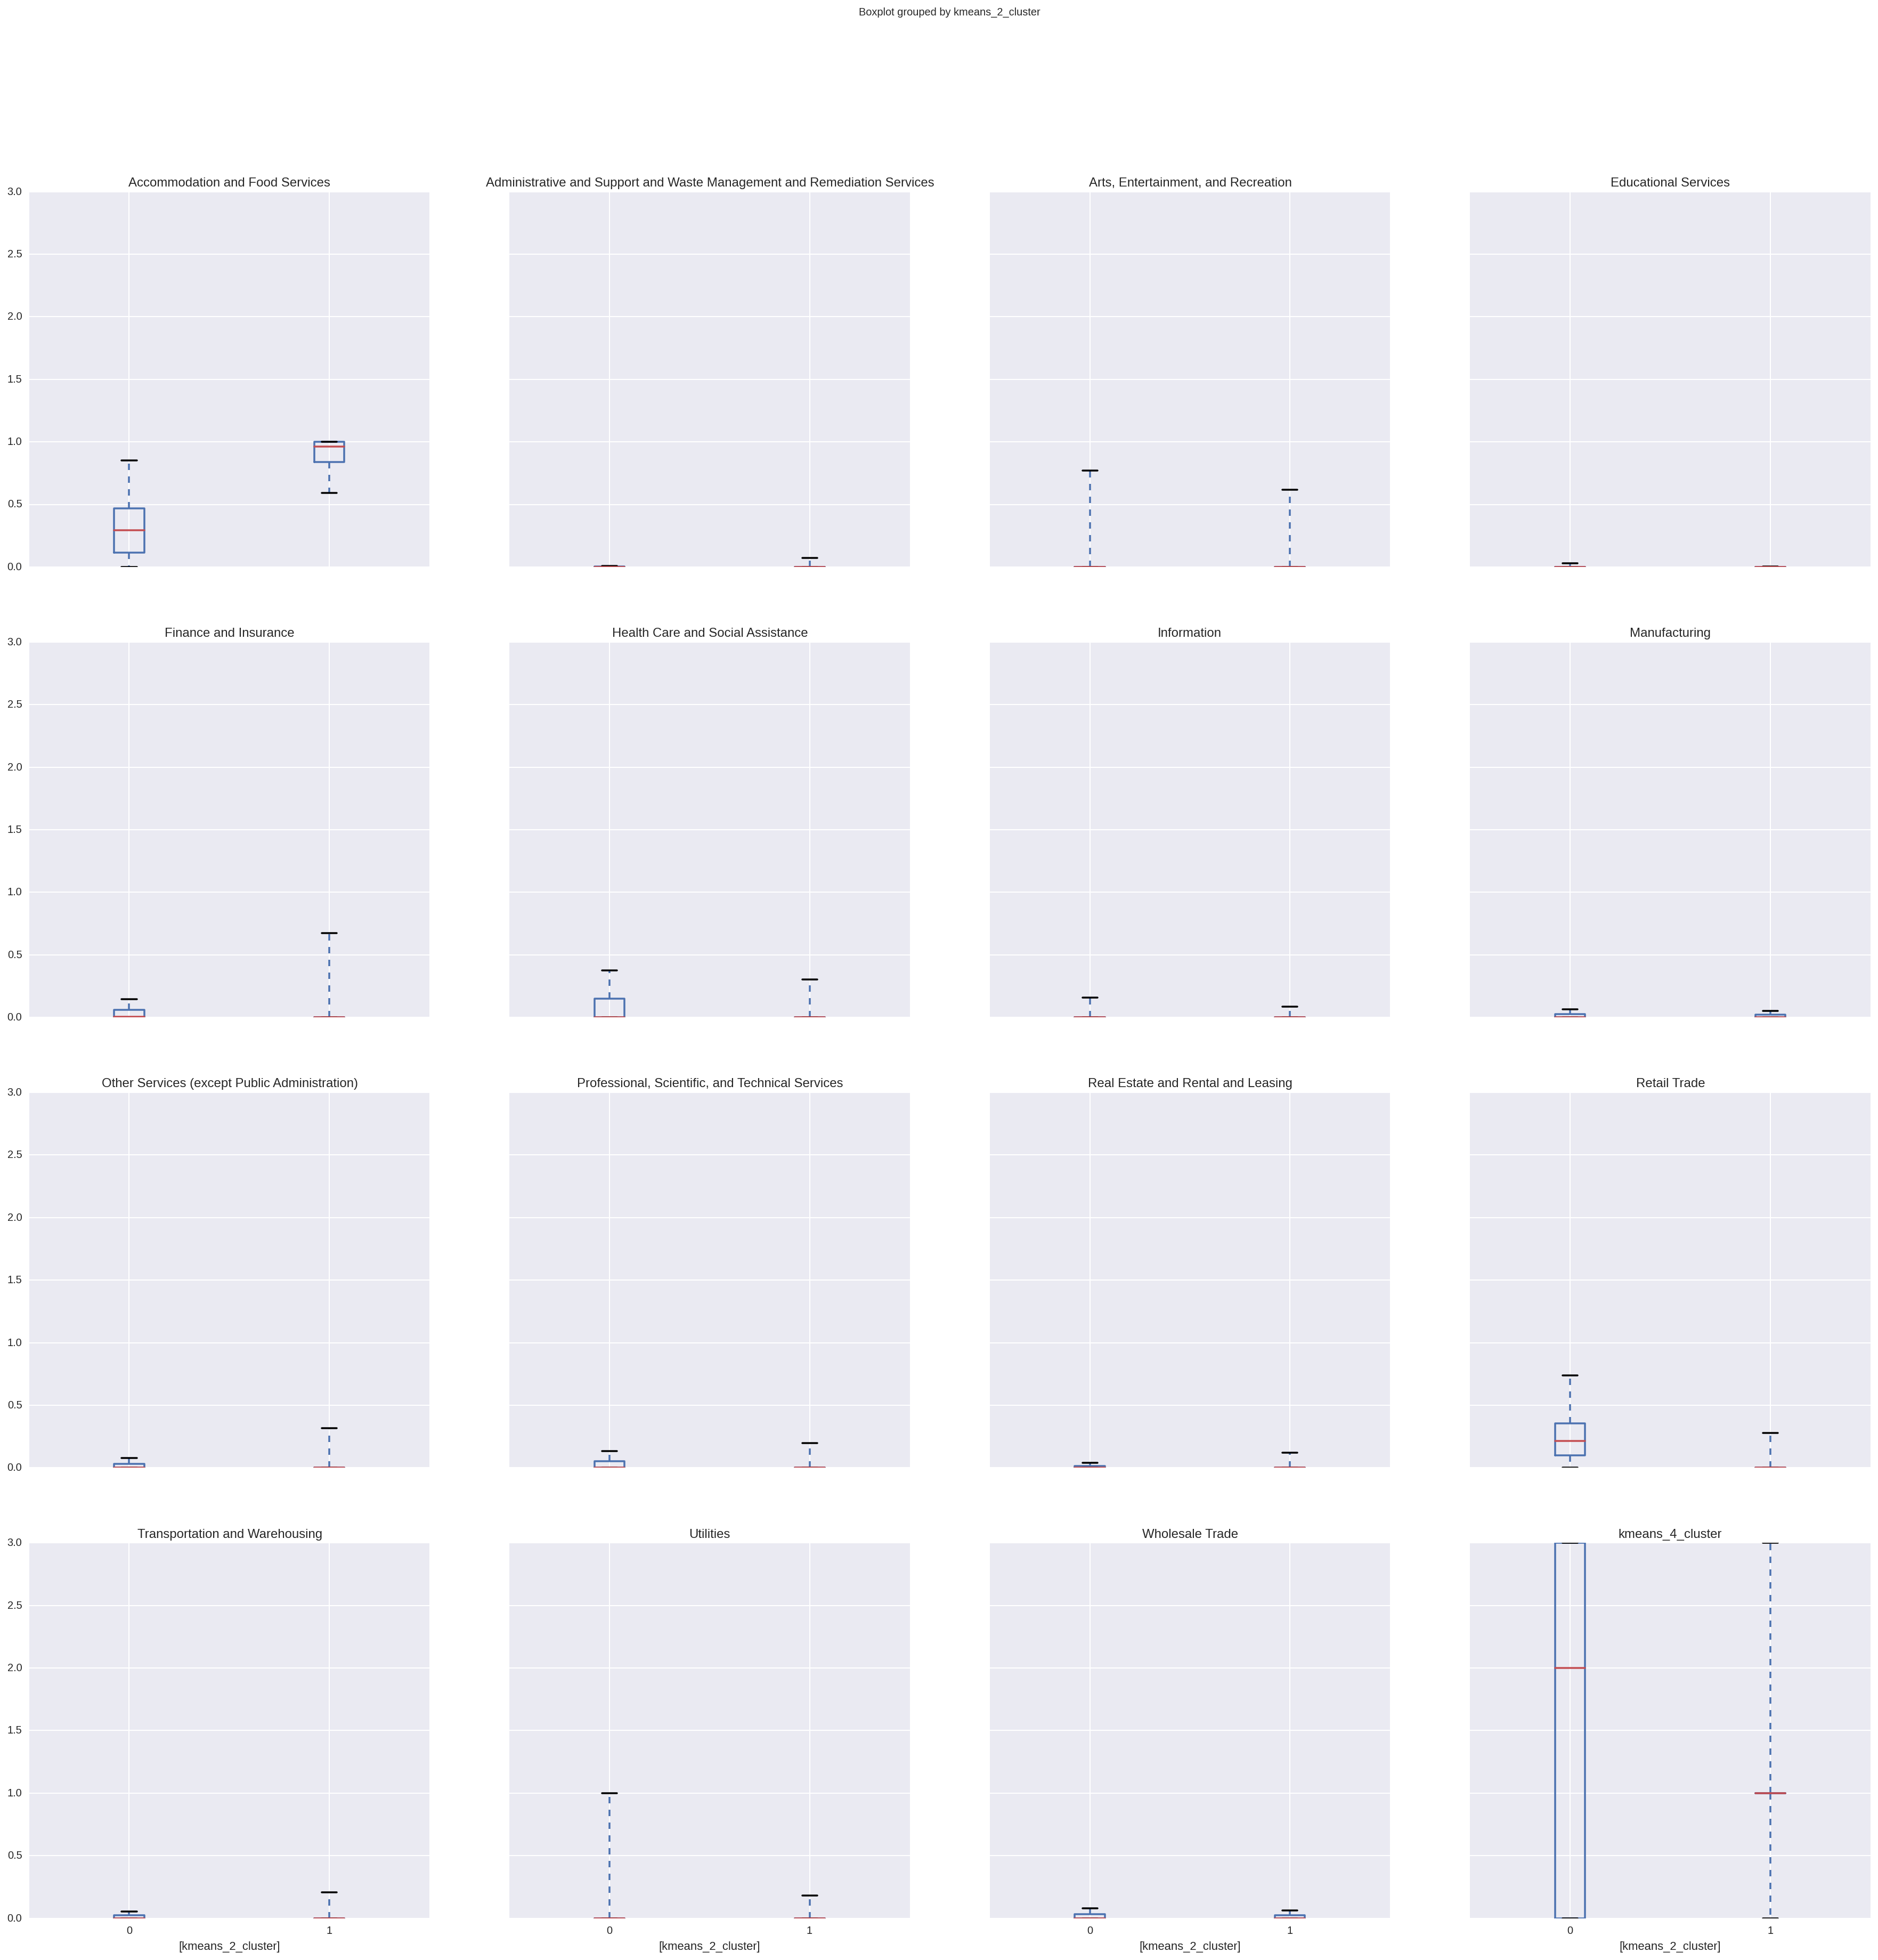

In [64]:
county_ind_prop_emp.boxplot(by='kmeans_2_cluster', figsize=(30,30))

In [65]:
county_ind_prop_rcp=county_ind_prop_pivot['ind_prop_county_rcp'].copy()
county_ind_prop_rcp.head()
county_ind_prop_rcp['kmeans_2_cluster']=county_ind_prop_pivot['kmeans_2_cluster']

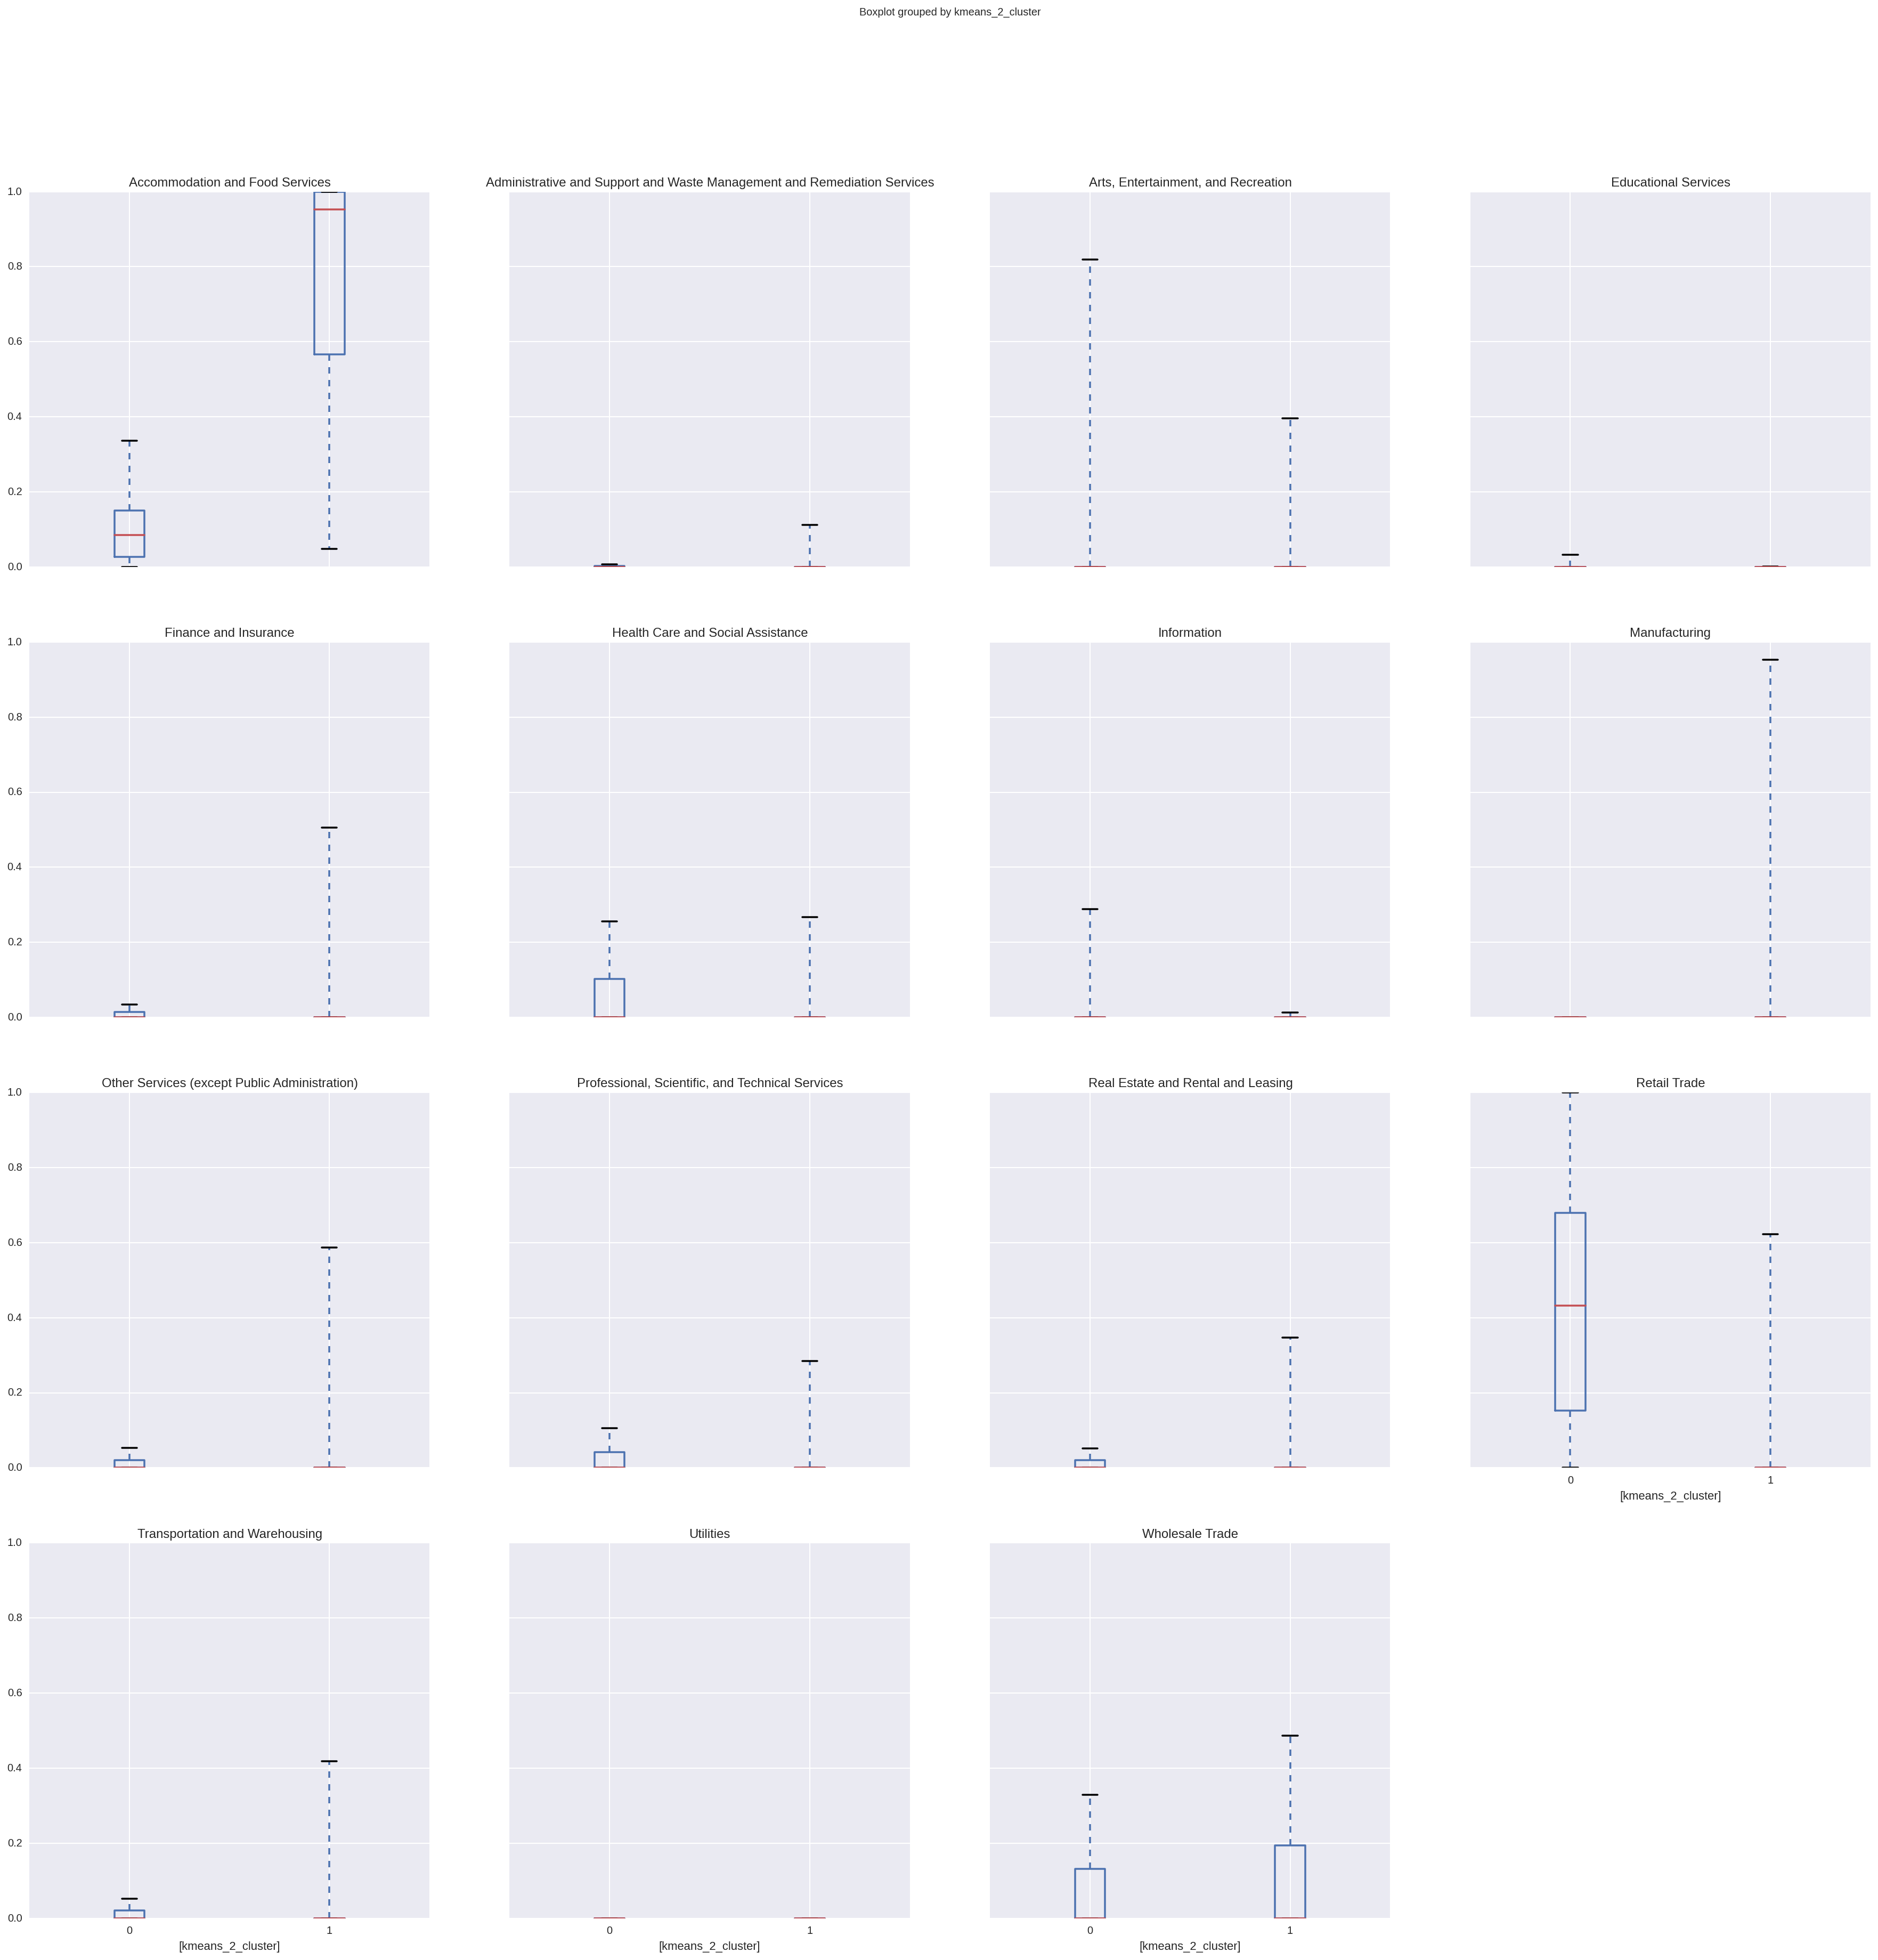

In [66]:
p5=county_ind_prop_rcp.boxplot(by='kmeans_2_cluster', figsize=(30,30))

In [67]:
county_ind_prop_pay=county_ind_prop_pivot['ind_prop_county_pay'].copy()
county_ind_prop_pay.head()
county_ind_prop_pay['kmeans_2_cluster']=county_ind_prop_pivot['kmeans_2_cluster']

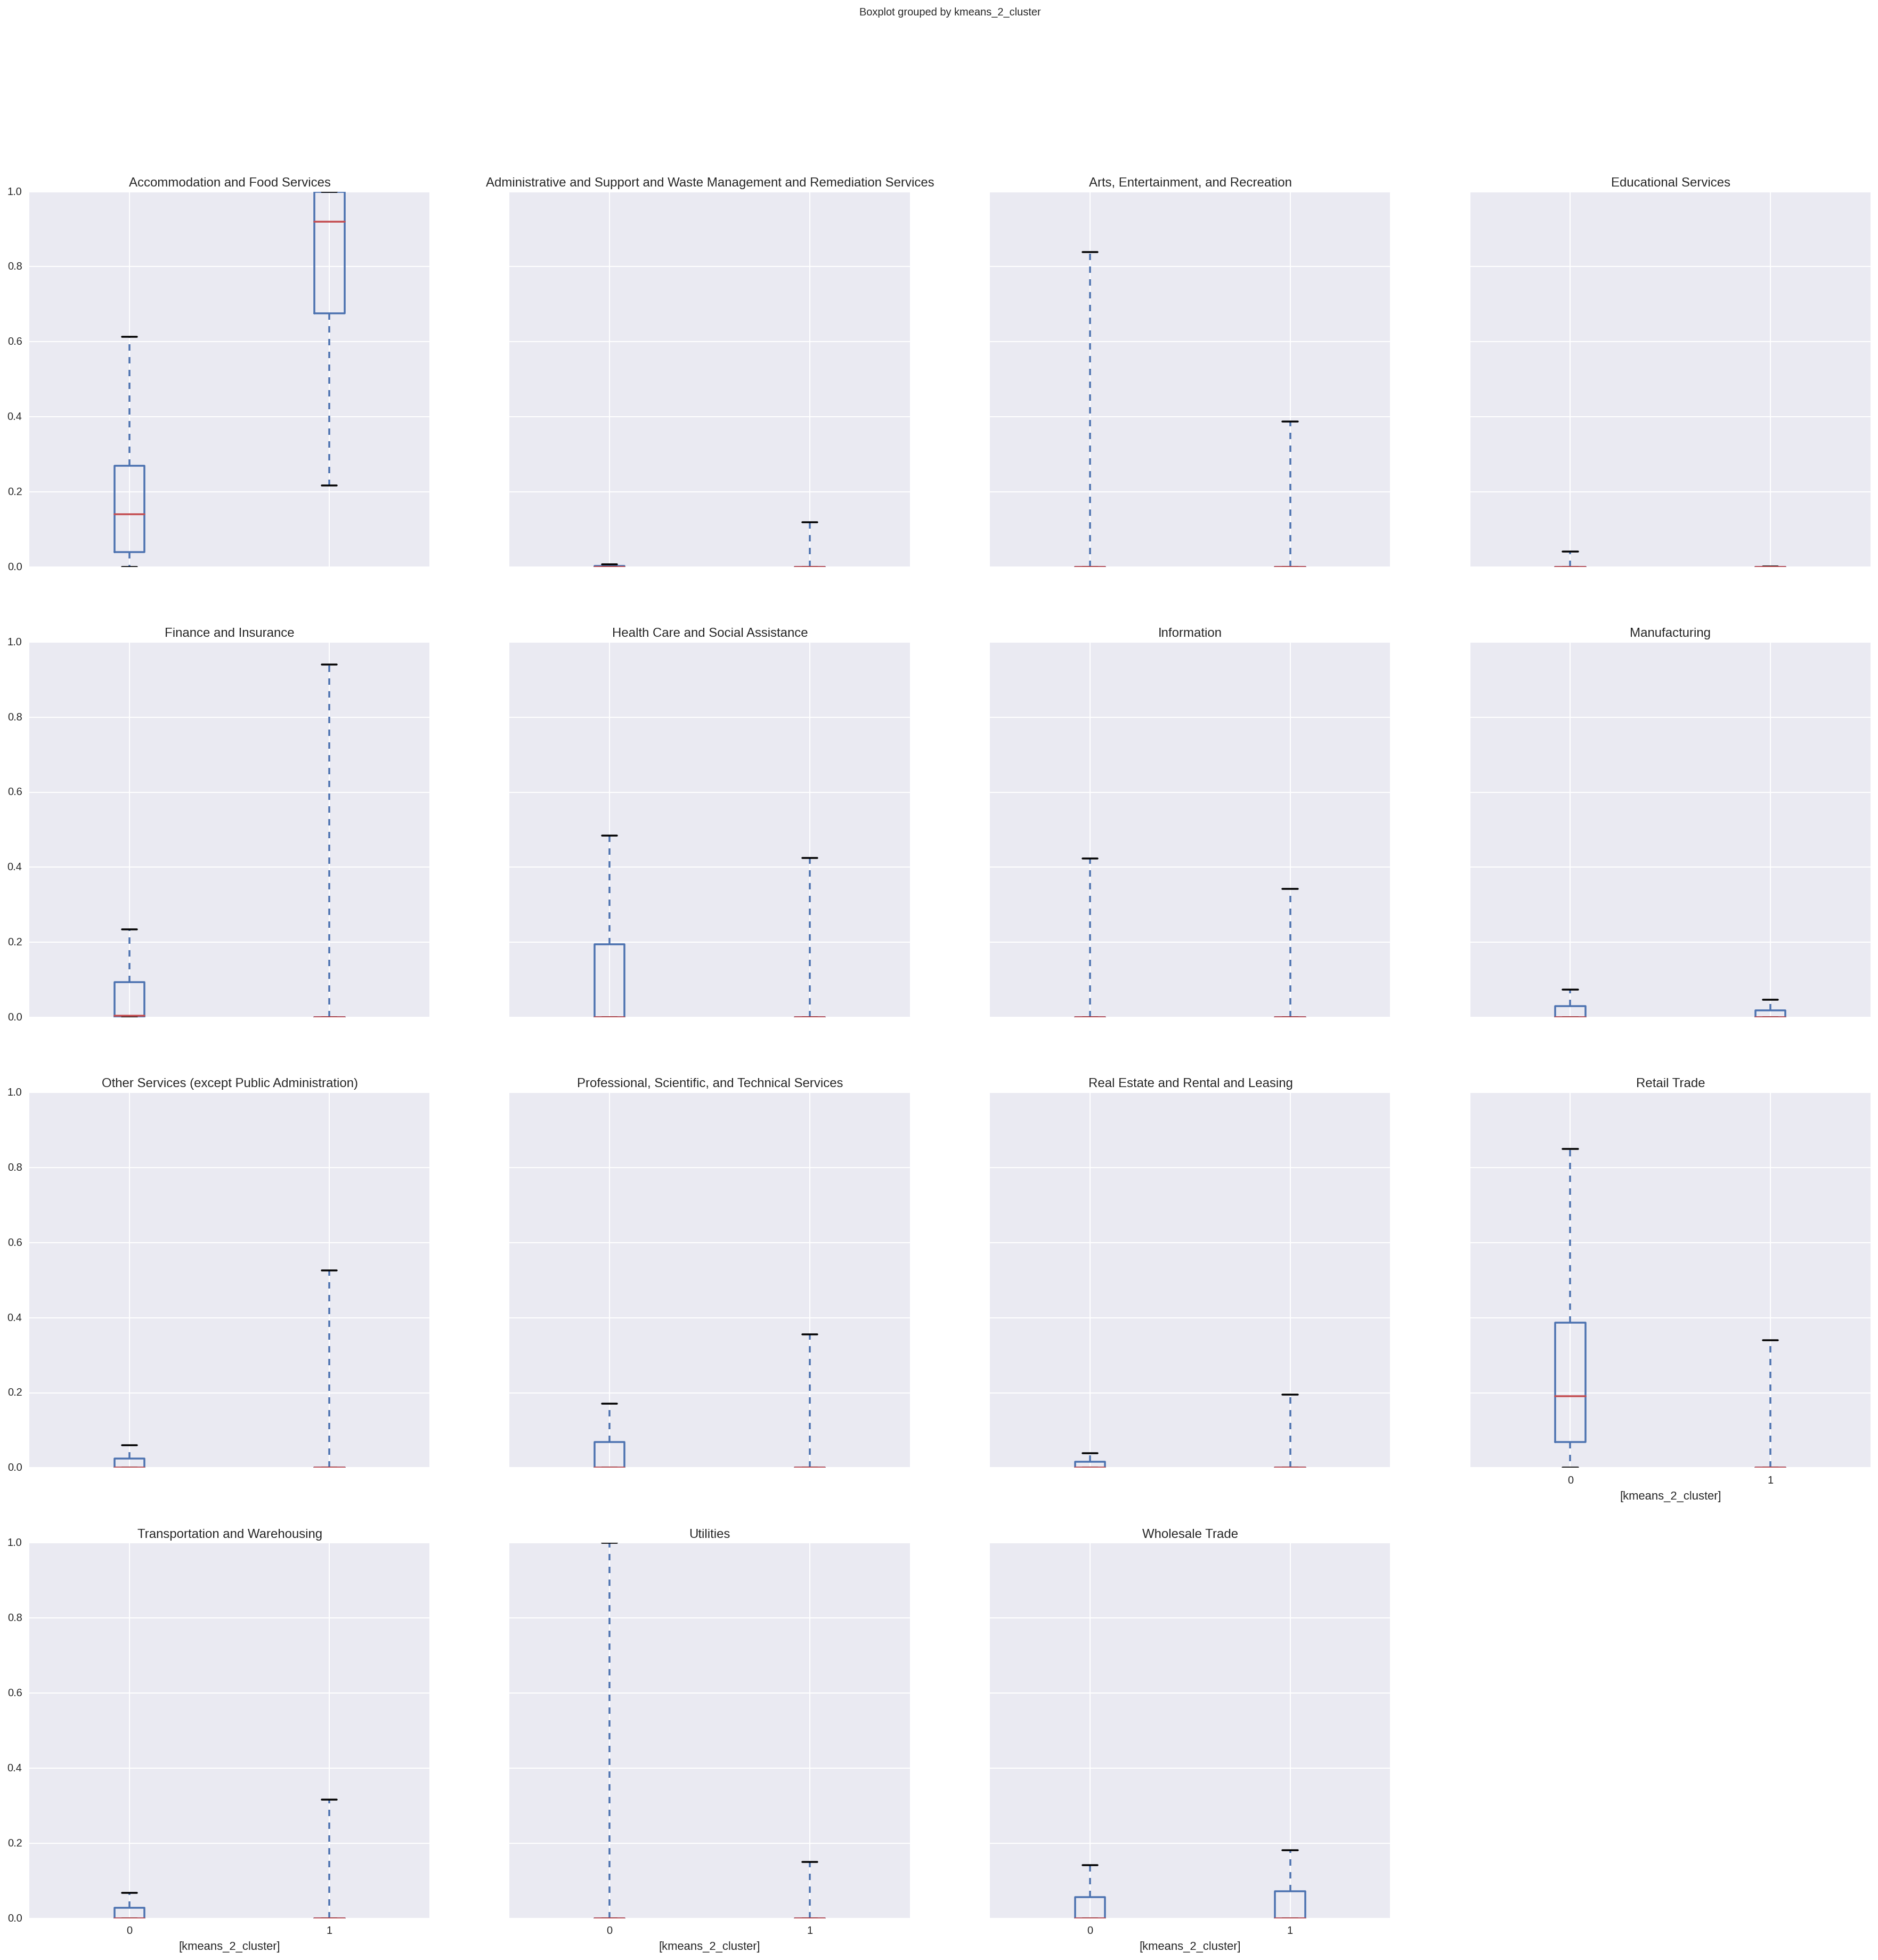

In [68]:
p4=county_ind_prop_pay.boxplot(by='kmeans_2_cluster', figsize=(30,30))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f824084f910>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f8240159410>]], dtype=object)

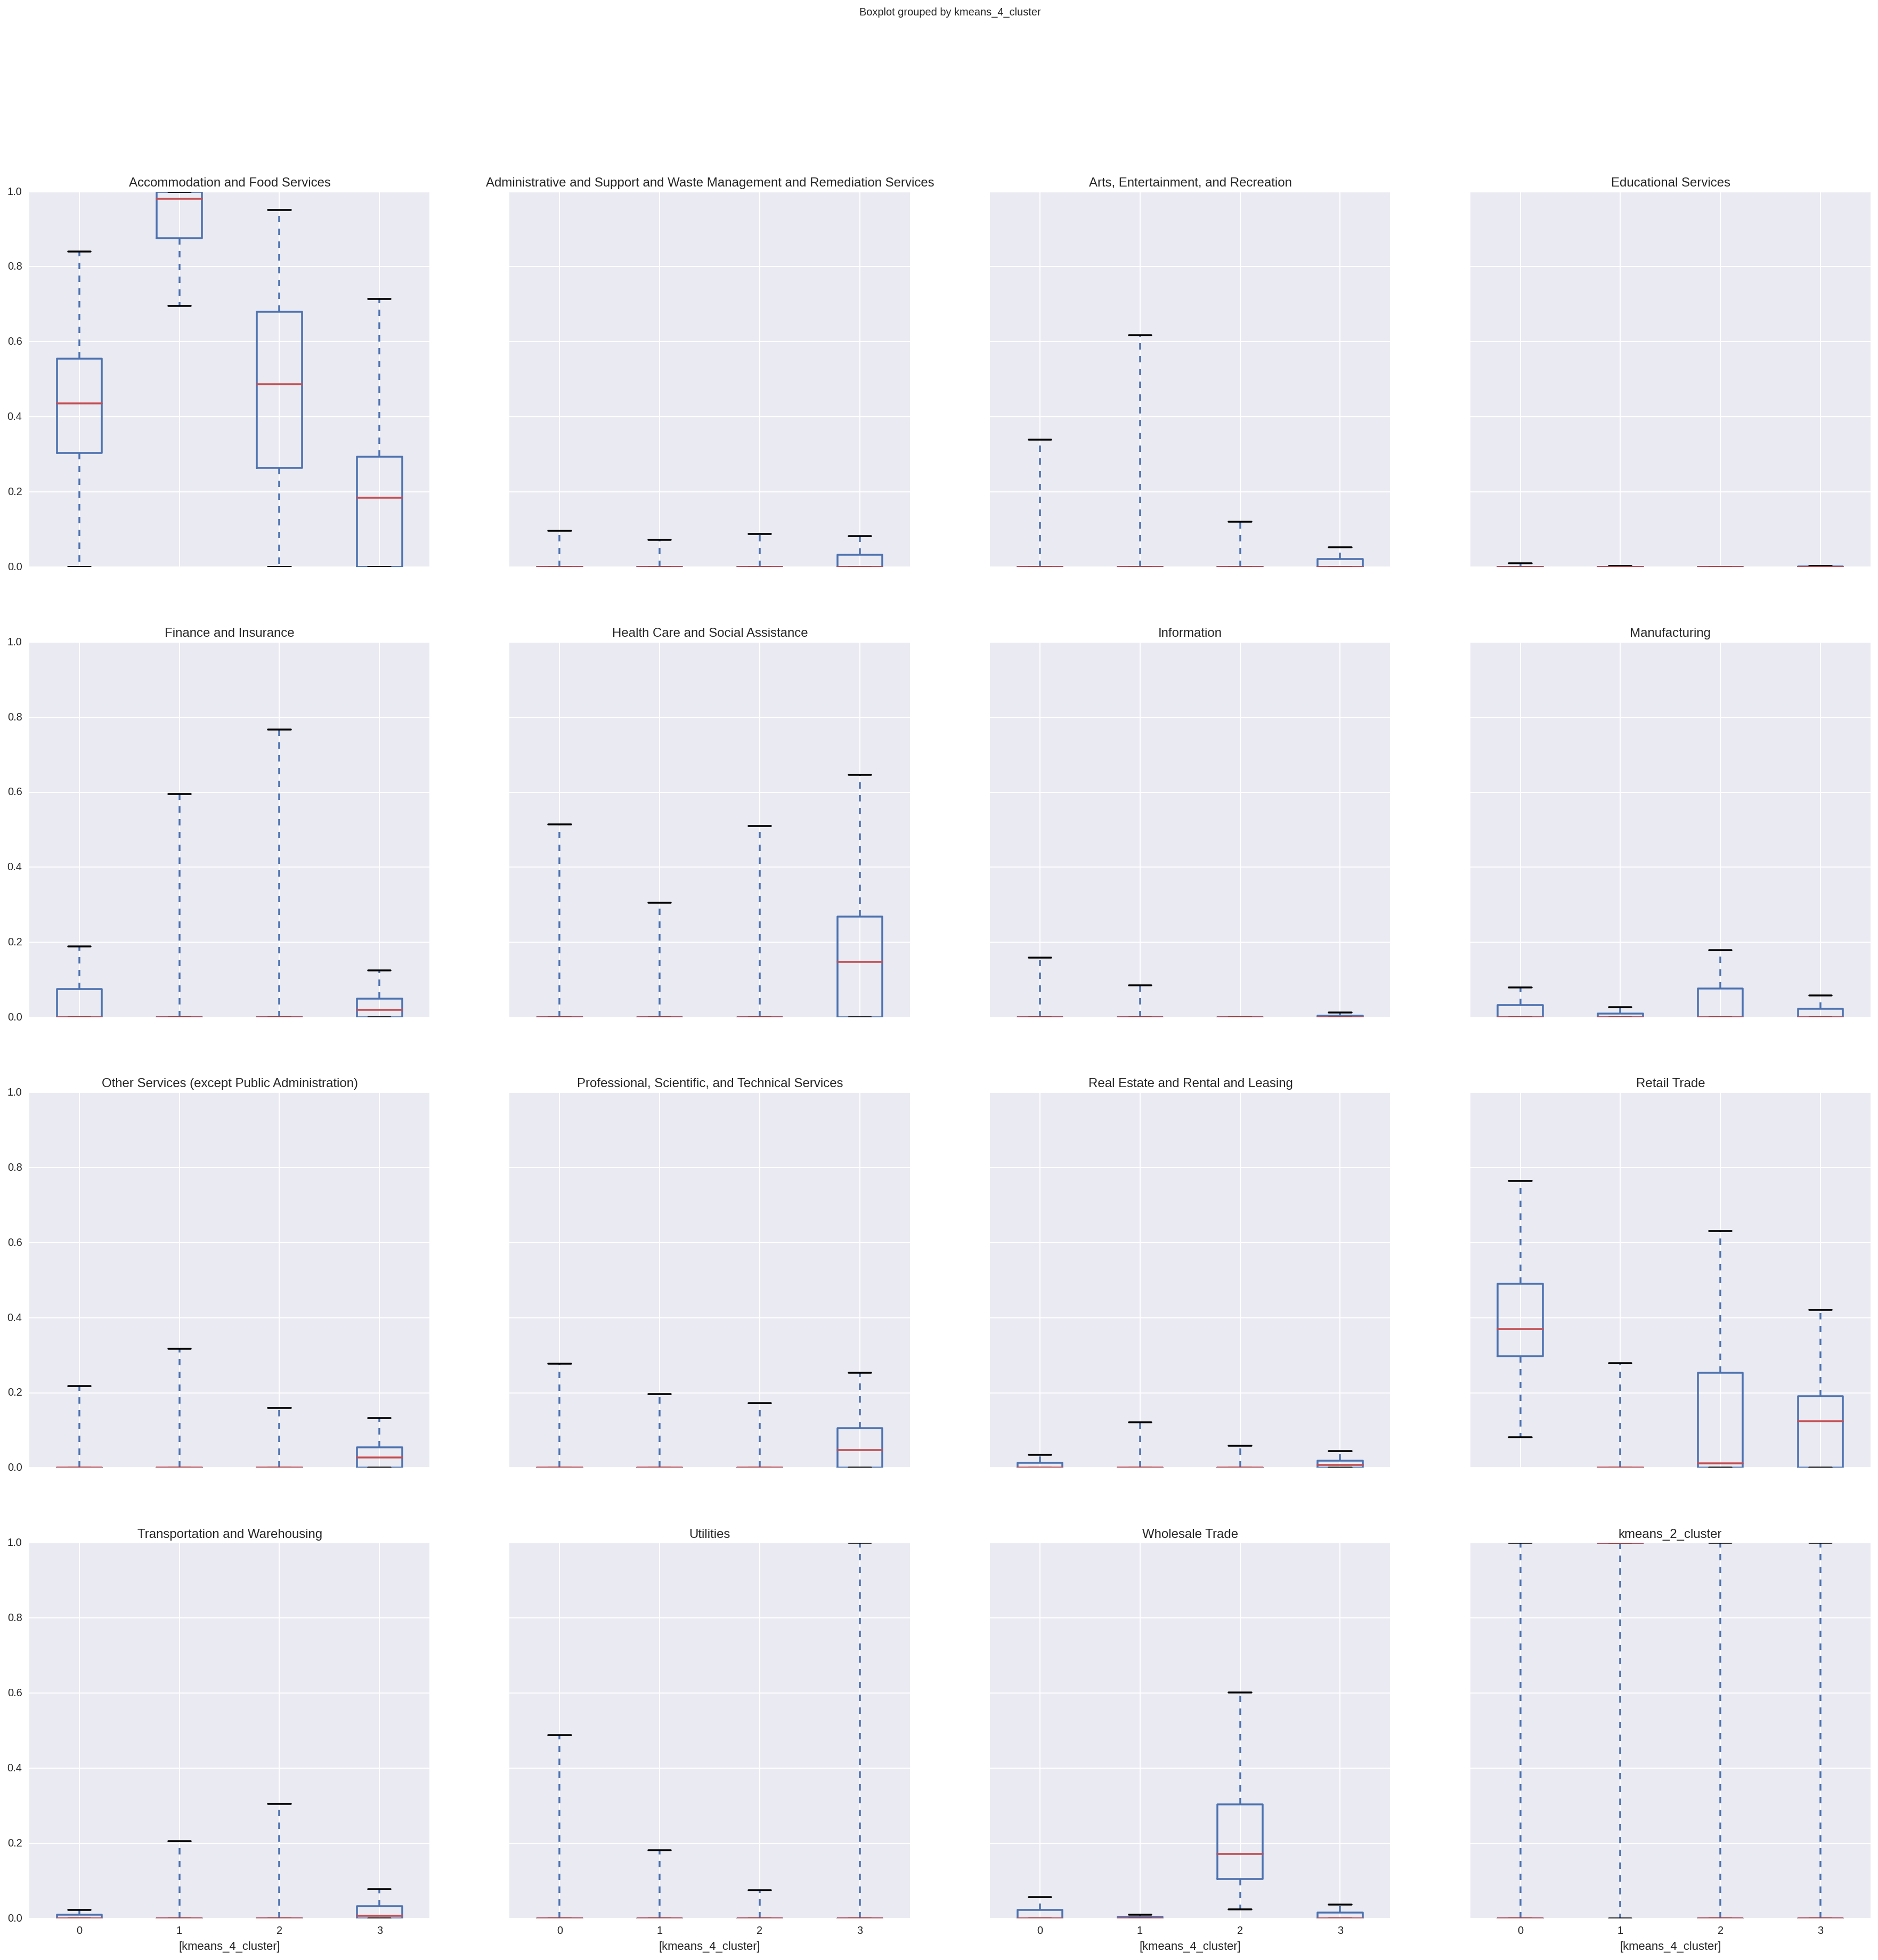

In [69]:
county_ind_prop_emp.boxplot(by='kmeans_4_cluster', figsize=(30,30))

In [70]:
# pl.savefig('kmeans_4_emp.pdf', pad_inches='tight')

In [71]:
county_ind_prop_rcp=county_ind_prop_pivot['ind_prop_county_rcp'].copy()
county_ind_prop_rcp.head()
county_ind_prop_rcp['kmeans_4_cluster']=county_ind_prop_pivot['kmeans_4_cluster']

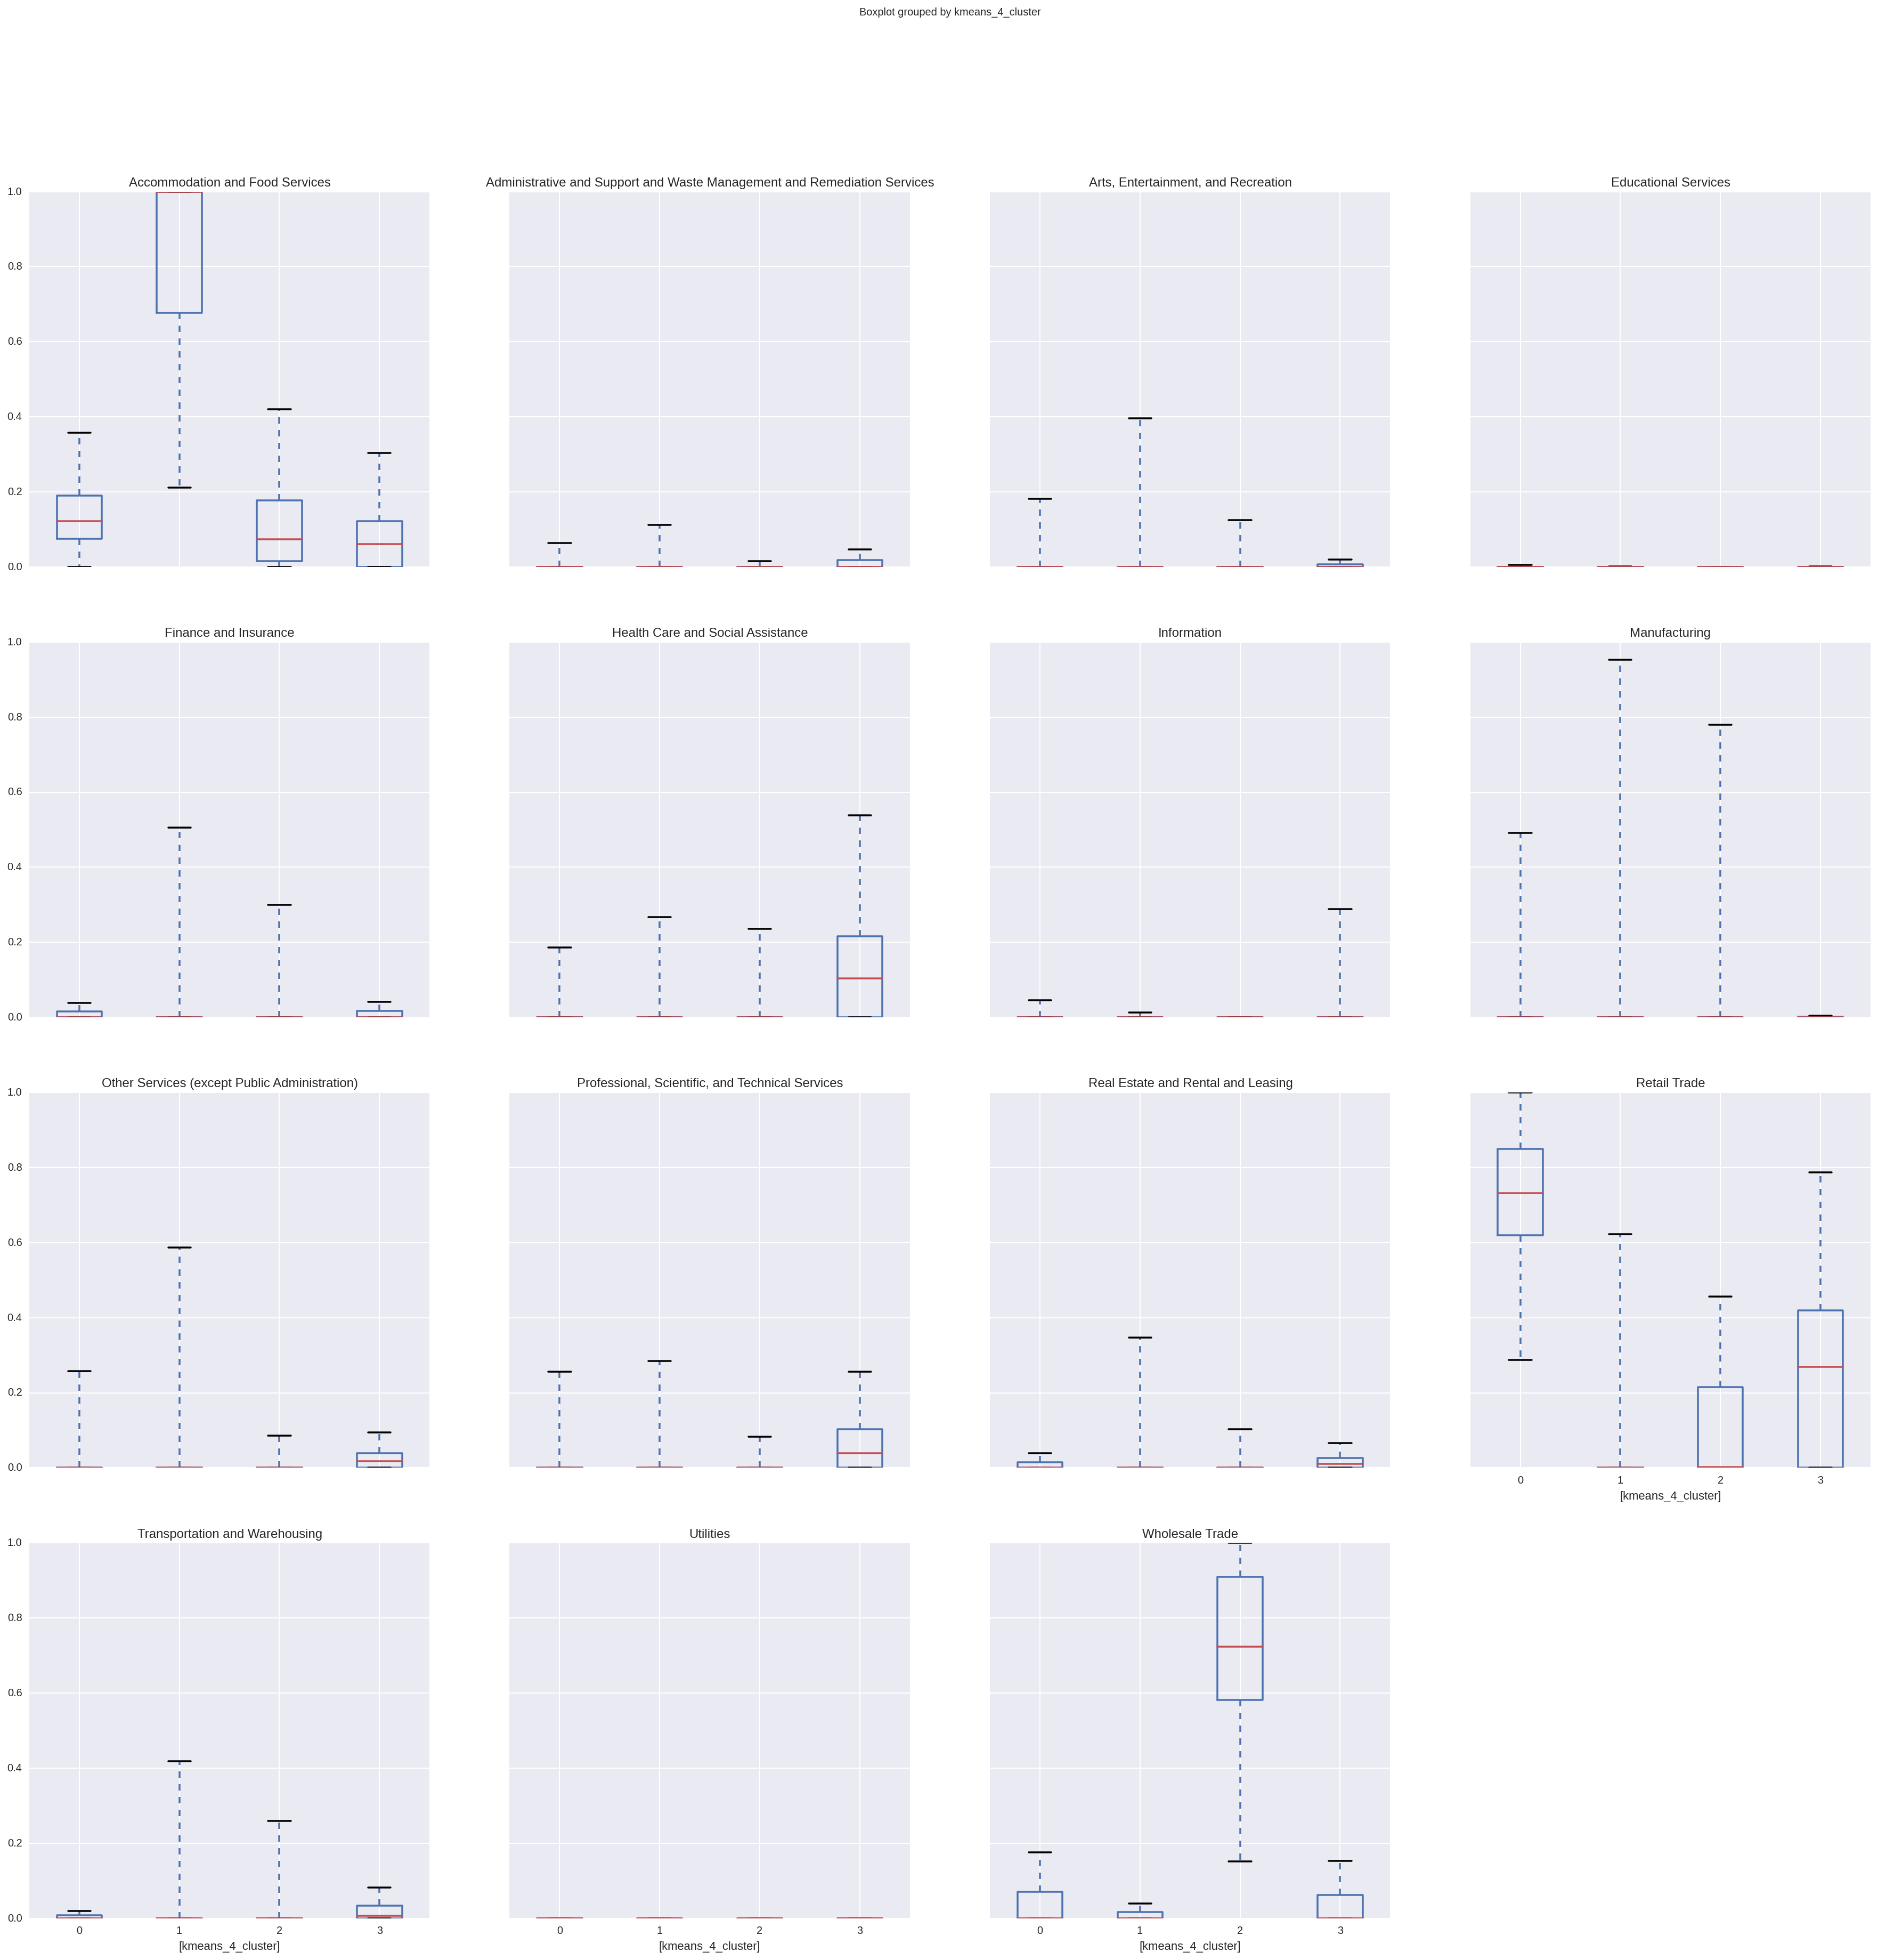

In [72]:
p4=county_ind_prop_rcp.boxplot(by='kmeans_4_cluster', figsize=(30,30))

In [73]:
county_ind_prop_pay=county_ind_prop_pivot['ind_prop_county_pay'].copy()
county_ind_prop_pay.head()
county_ind_prop_pay['kmeans_4_cluster']=county_ind_prop_pivot['kmeans_4_cluster']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f823b55d710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f822d61c550>]], dtype=object)

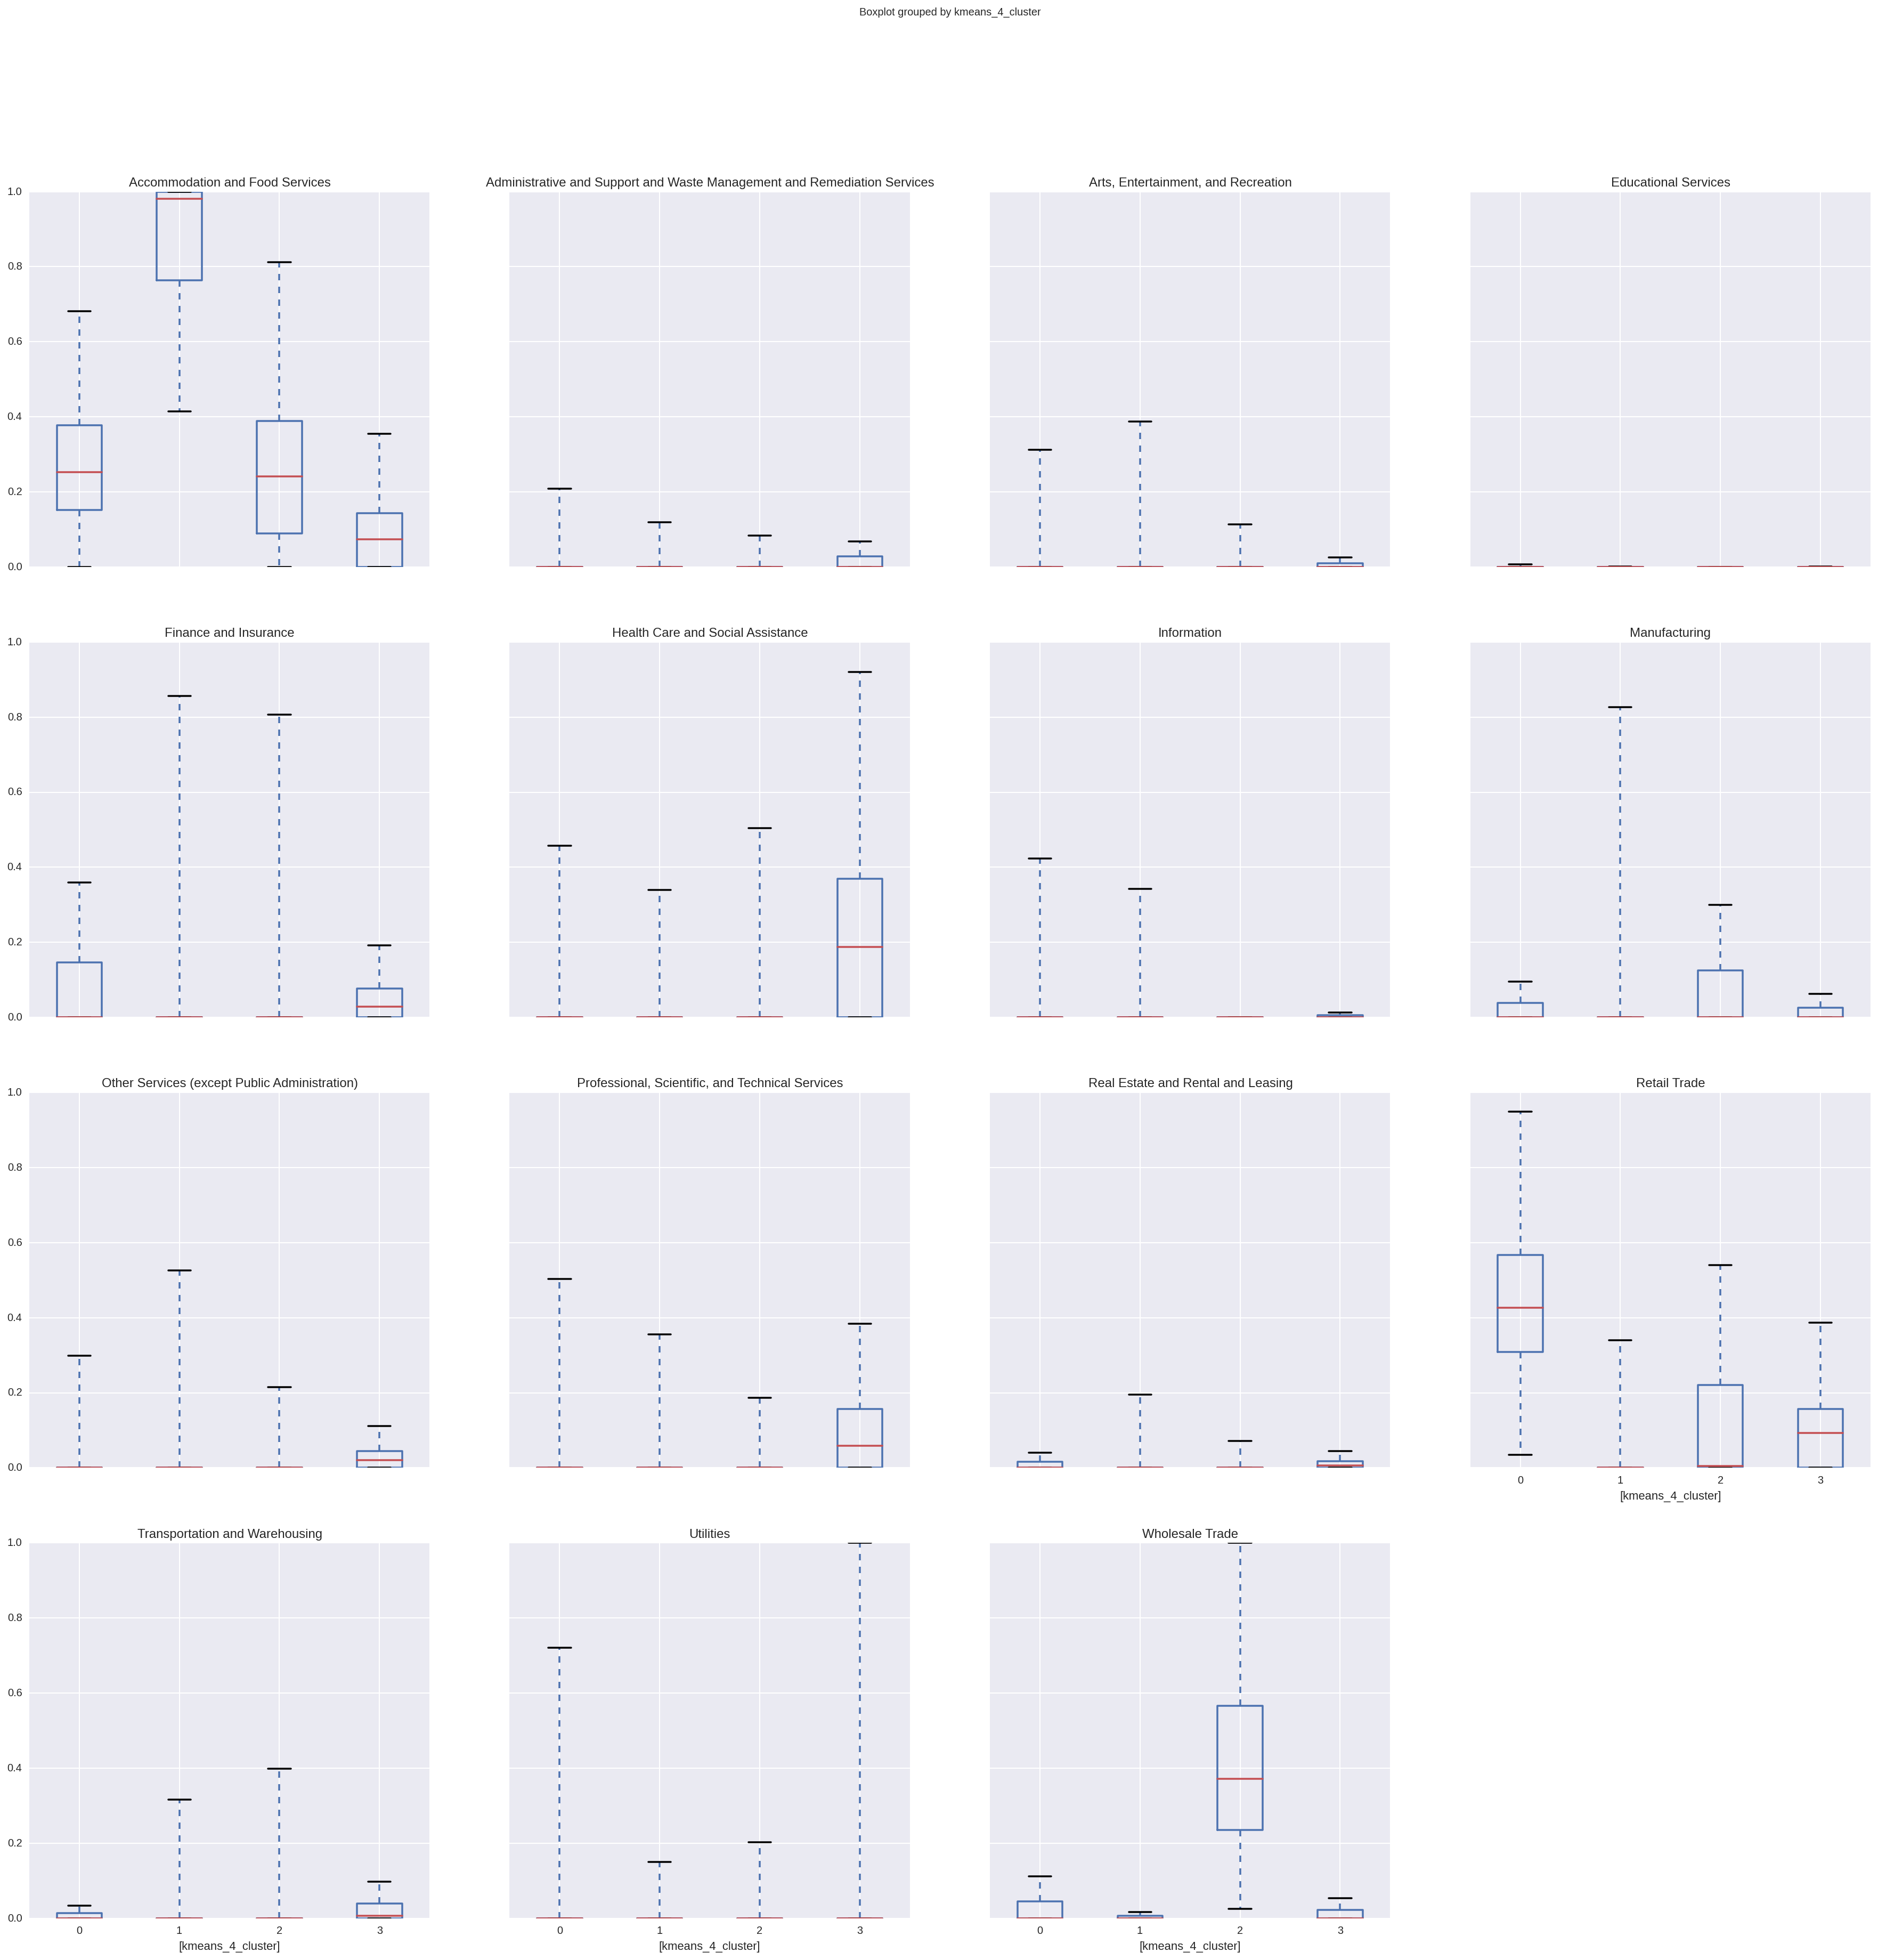

In [74]:
county_ind_prop_pay.boxplot(by='kmeans_4_cluster', figsize=(30,30))

In [75]:
county_ind_prop_pivot.to_csv('county_ind_prop_pivot.csv', sep=',',index=True, encoding='utf-8' )

In [76]:
industryDF.head()

,CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX,NAICS2012.1,...,NAICS_2digit,Industry_Desc,Industry_Group,state_county_code,state_abbrev,state_fp,county_fp,countyName,fp_class_code,st_county_id_str
0,999,1,15,221111,0,0,0,1,99,221111,...,22,Hydroelectric Power Generation,Utilities,1015,AL,1,15,Calhoun County,H1,01015
1,999,1,15,221115,0,0,0,1,99,221115,...,22,Wind Electric Power Generation,Utilities,1015,AL,1,15,Calhoun County,H1,01015
2,999,1,15,221122,0,0,0,9,99,221122,...,22,Electric Power Distribution,Utilities,1015,AL,1,15,Calhoun County,H1,01015
3,999,1,15,221210,0,0,0,1,99,221210,...,22,Natural Gas Distribution,Utilities,1015,AL,1,15,Calhoun County,H1,01015
4,999,1,15,221310,0,0,0,1,99,221310,...,22,Water Supply and Irrigation Systems,Utilities,1015,AL,1,15,Calhoun County,H1,01015


In [77]:
by_ST=industryDF[['state_abbrev','Industry_Group', 'EMP','RCPTOT','PAYANN']].groupby(['state_abbrev']).sum()

In [78]:
by_ST

,EMP,RCPTOT,PAYANN
state_abbrev,,,
AK,112359,16103745,4740814
AL,350277,65987690,10396297
AR,97564,11821734,1821407
AZ,1271948,209266067,51602673
CA,11393870,2088402872,561608049
CO,1305468,202351627,59144511
CT,1067504,179930646,53897092
DC,452823,100189834,33636532
DE,177211,51833174,8394016


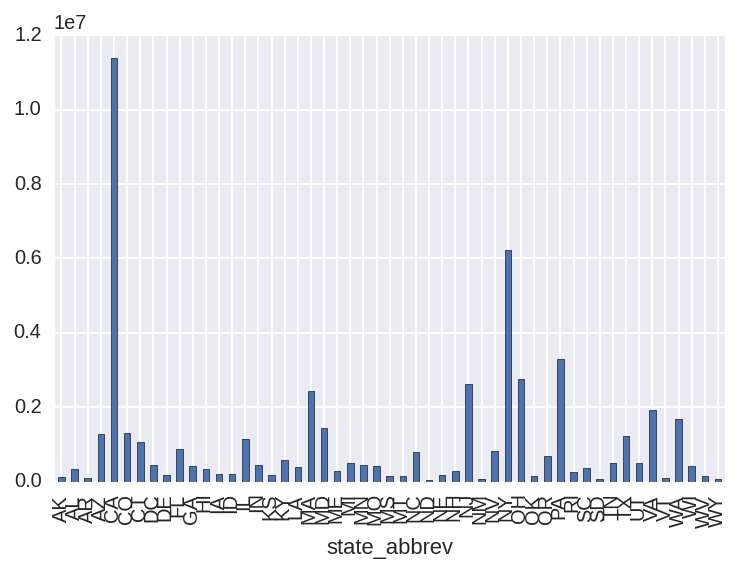

In [79]:
p1=by_ST['EMP'].plot(kind='bar')
# workforce_by_state=workforce_by_state.reset_index()
# workforce_by_state.columns=['state_abbrev', 'ST_tot_emp']
# workforce_by_state.head()
# industryDF=pd.merge(industryDF, workforce_by_state, on='state_abbrev' )
# industryDF.head()

In [80]:
fig = state_emp.get_figure()
fig.savefig('keans_cluster_compare.pdf', pad_inches='tight')

NameError: name 'state_emp' is not defined

In [81]:
emp_by_industry=industryDF[['Industry_Group', 'EMP']].groupby('Industry_Group')

,Industry_Group,Industry_tot_emp
0,Accommodation and Food Services,10319062
1,Administrative and Support and Waste Managemen...,2873452
2,"Arts, Entertainment, and Recreation",1098810
3,Educational Services,445487
4,Finance and Insurance,2392204


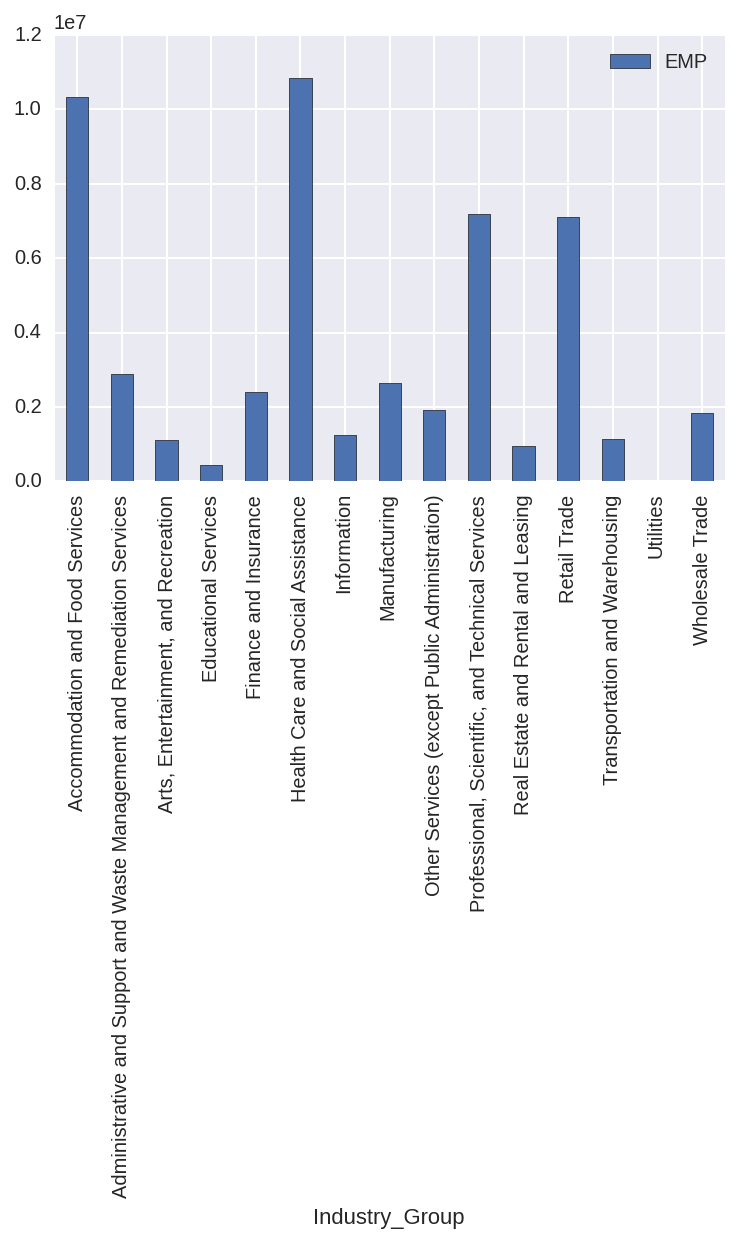

In [82]:
workforce_by_industry=emp_by_industry.sum()
industry_emp=workforce_by_industry.plot(kind='bar')
workforce_by_industry=workforce_by_industry.reset_index()
workforce_by_industry.columns=['Industry_Group', 'Industry_tot_emp']
workforce_by_industry.head()

In [83]:
fig = industry_emp.get_figure()
fig.savefig('keans_cluster_compare.pdf', pad_inches='tight')

In [84]:
industryDF.tail()

,CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX,NAICS2012.1,...,NAICS_2digit,Industry_Desc,Industry_Group,state_county_code,state_abbrev,state_fp,county_fp,countyName,fp_class_code,st_county_id_str
444397,999,48,125,722511,0,0,0,3,99,722511,...,72,Full-Service Restaurants,Accommodation and Food Services,48125,TX,48,125,Dickens County,H1,48125
444398,999,48,125,722513,0,0,0,2,99,722513,...,72,Limited-Service Restaurants,Accommodation and Food Services,48125,TX,48,125,Dickens County,H1,48125
444399,999,48,393,722511,0,0,0,1,99,722511,...,72,Full-Service Restaurants,Accommodation and Food Services,48393,TX,48,393,Roberts County,H1,48393
444400,999,13,265,722513,0,0,0,1,99,722513,...,72,Limited-Service Restaurants,Accommodation and Food Services,13265,GA,13,265,Taliaferro County,H1,13265
444401,999,48,263,722513,0,0,0,1,99,722513,...,72,Limited-Service Restaurants,Accommodation and Food Services,48263,TX,48,263,Kent County,H1,48263


In [ ]:
industryDF=pd.merge(industryDF, workforce_by_industry, on='Industry_Group' )

In [ ]:

# workforce_by_state.columns=['index', 'state_abbrev', 'ST_tot_emp']
workforce_by_state.head()

In [ ]:
industryDF.columns

In [ ]:
by_both=industryDF[['ST','Industry_Group', 'EMP']].groupby(['ST','Industry_Group'])

In [ ]:
output = open('industryDF.pkl', 'wb')
pickle.dump(industryDF, output)
output.close()

In [ ]:
emp_by_county=industryDF[['state_county_code', 'EMP']].groupby('state_county_code')

In [ ]:
workforce_by_county=emp_by_county.sum()

In [ ]:
workforce_by_county=emp_by_county.sum()
# workforce_by_county.plot(kind='bar')
workforce_by_county=workforce_by_county.reset_index()
workforce_by_county.columns=['state_county_code', 'county_tot_emp']

In [ ]:
workforce_by_county.head()

In [ ]:
http://api.census.gov/data/2012/ewks?get=EMP,NAICS2012_TTL,OPTAX,GEO_TTL&for=place:07000&in=state:01+county:073&NAICS2012=31-33

In [ ]:
column_names=re.split(',', 'CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX')
base_url='http://api.census.gov/data/2012/ewks?get=CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX&for=place:*&in=state:06&NAICS2012='
and_key='&key=77912556e5965544a3093efa3cb2305807fbe56c'
session = FuturesSession(max_workers=15)
urls=[]
for industry in industry_codes['NAICS2012']:
    urls.append(base_url+industry.strip()+and_key)
#     print base_url+industry+and_key
    
#Send multiple requests at once
futures = [session.get(url) for url in urls]
industry_responses = [future.result() for future in futures]

In [ ]:
industryDF=pd.merge(industryDF, workforce_by_county, on='st_county_id' )

In [ ]:
industryDF['prop_emp_ind_county']=industryDF['EMP']*1.0/industryDF['county_tot_emp']

In [ ]:
output = open('industryDF_with_Aggs.pkl', 'wb')
pickle.dump(industryDF, output)
output.close()

In [ ]:
pkl_file = open('industryDF_with_Aggs.pkl', 'rb')
industryDF = pickle.load(pkl_file)

In [ ]:
industryDF.columns